In [1]:
import warnings
import awkward as ak
import numpy as np
import hist as hs
from hist.intervals import ratio_uncertainty

from coffea import processor
from coffea.nanoevents.methods import vector, candidate
from numba import jit

from coffea.nanoevents import BaseSchema
import mplhep as hep
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from datetime import date
today = date.today()

plt.style.use(hep.style.CMS)
#plt.style.use('dark_background')

In [46]:
class LLP_ntuple_processor(processor.ProcessorABC):
    
    def delta_cls_gLLP(self, events):
        clusts = ak.zip(
            {
                'pt': ak.zeros_like(events.cscRechitClusterPhi),
                'phi': events.cscRechitClusterPhi,
                'eta': events.cscRechitClusterEta,
                'E': ak.zeros_like(events.cscRechitClusterPhi),
            },
            with_name = 'PtEtaPhiMLorentzVector',
            behavior = vector.behavior,                 
          )
        gLLPs = ak.zip(
            {
                'pt': events.gLLP_pt,
                'phi': events.gLLP_phi,
                'eta': events.gLLP_eta,
                'E': events.gLLP_e,
            },
            with_name = 'PtEtaPhiMLorentzVector',
            behavior = vector.behavior,                 
          )        
        cls_llp_pairs = ak.cartesian({
            "cls": clusts, 
            "llp": gLLPs
        }, nested = True) 
        
        deltaR = (cls_llp_pairs.cls).delta_r(cls_llp_pairs.llp)
        deltaEta = abs(cls_llp_pairs.cls.eta - cls_llp_pairs.llp.eta)
        deltaPhi = np.arctan2(np.sin(cls_llp_pairs.cls.phi - cls_llp_pairs.llp.phi), 
                              np.cos(cls_llp_pairs.cls.phi - cls_llp_pairs.llp.phi))
        
        deltaR, deltaEta, deltaPhi = ak.flatten(deltaR, axis=2), ak.flatten(deltaEta, axis=2), ak.flatten(deltaPhi, axis=2)
        return deltaR, deltaEta, deltaPhi,
    
    def delta_cls_leadmuon(self, events):
        clusts = ak.zip(
            {
                'pt': ak.zeros_like(events.cscRechitClusterPhi),
                'phi': events.cscRechitClusterPhi,
                'eta': events.cscRechitClusterEta,
                'E': ak.zeros_like(events.cscRechitClusterPhi),
            },
            with_name = 'PtEtaPhiMLorentzVector',
            behavior = vector.behavior,                 
          )
        leadMuons = ak.zip(
            {
                'pt': events.leadMuonPt,
                'phi': events.leadMuonPhi,
                'eta': events.leadMuonEta,
                'E': events.leadMuonE,
            },
            with_name = 'PtEtaPhiMLorentzVector',
            behavior = vector.behavior,                 
          ) 
        cls_muon_pairs = ak.cartesian({
            "cls": clusts, 
            "muon": leadMuons
        }, nested = True)
 
        deltaR = (cls_muon_pairs.cls).delta_r(cls_muon_pairs.muon)
        deltaEta = abs(cls_muon_pairs.cls.eta - cls_muon_pairs.muon.eta)
        deltaPhi = np.arctan2(np.sin(cls_muon_pairs.cls.phi - cls_muon_pairs.muon.phi), 
                              np.cos(cls_muon_pairs.cls.phi - cls_muon_pairs.muon.phi))
        
        deltaR, deltaEta, deltaPhi = ak.flatten(deltaR, axis=2), ak.flatten(deltaEta, axis=2), ak.flatten(deltaPhi, axis=2)
        return deltaR, deltaEta, deltaPhi
        
    
    def process(self, events):
        
        signame = 'Phi'
        
        # >>> output dict init >>>
        dataset = events.metadata['dataset']
        out = {
            dataset: {},
            f'{dataset}_cuts': {},
            f'{dataset}_vars': {},
        }
        # <<< output dict init <<<
        
        out[dataset][f'numEvents_pretrigger'] = len(events)
        
        # >>> some preprocessing >>>
        muoncut = abs(events.lepPdgId) == 13
        events['muonE'] = events.lepE[muoncut]
        events['muonPt'] = events.lepPt[muoncut]
        events['muonEta'] = events.lepEta[muoncut]
        events['muonPhi'] = events.lepPhi[muoncut]
        events['muonPdgId'] = events.lepPdgId[muoncut]
        events['muonDZ'] = events.lepDZ[muoncut]
        events['muonLooseId'] = events.lepLooseId[muoncut]
        events['muonTightId'] = events.lepTightId[muoncut] 
        events['muonType'] = events.lepMuonType[muoncut]
        events['muonQuality'] = events.lepMuonQuality[muoncut]
        events['muon_passHLTFilter'] = events.lepMuon_passHLTFilter[muoncut]
        events = events[ak.count(events.muonPt, axis=1) > 0] #kill all events with empty muons
        out[dataset][f'numEvents_|muonId| == 13'] = len(events.muonPt)
        
        muoncut = abs(events.muonEta) < 1.5
        events['muonE'] = events.muonE[muoncut]
        events['muonPt'] = events.muonPt[muoncut]
        events['muonEta'] = events.muonEta[muoncut]
        events['muonPhi'] = events.muonPhi[muoncut]
        events['muonPdgId'] = events.muonPdgId[muoncut]
        events['muonDZ'] = events.muonDZ[muoncut]
        events['muonLooseId'] = events.muonLooseId[muoncut]
        events['muonTightId'] = events.muonTightId[muoncut]
        events['muonType'] = events.muonType[muoncut]
        events['muonQuality'] = events.muonQuality[muoncut]
        events['muon_passHLTFilter'] = events.muon_passHLTFilter[muoncut]
        events = events[ak.count(events.muonPt, axis=1) > 0] #kill all events with empty muons
        out[dataset][f'numEvents_|muonEta| < 1.5'] = len(events.muonPt)
        
        muoncut = events.muonPt > 7
        events['muonE'] = events.muonE[muoncut]
        events['muonPt'] = events.muonPt[muoncut]
        events['muonEta'] = events.muonEta[muoncut]
        events['muonPhi'] = events.muonPhi[muoncut]
        events['muonPdgId'] = events.muonPdgId[muoncut]
        events['muonDZ'] = events.muonDZ[muoncut]
        events['muonLooseId'] = events.muonLooseId[muoncut]
        events['muonTightId'] = events.muonTightId[muoncut]
        events['muonType'] = events.muonType[muoncut]
        events['muonQuality'] = events.muonQuality[muoncut]
        events['muon_passHLTFilter'] = events.muon_passHLTFilter[muoncut]
        events = events[ak.count(events.muonPt, axis=1) > 0] #kill all events with empty muons
        out[dataset][f'numEvents_muonPt > 7'] = len(events.muonPt)

        muoncut = ak.any(events.muon_passHLTFilter[:,:,range(60,68)], axis=2)
        events['muonE'] = events.muonE[muoncut]
        events['muonPt'] = events.muonPt[muoncut]
        events['muonEta'] = events.muonEta[muoncut]
        events['muonPhi'] = events.muonPhi[muoncut]
        events['muonPdgId'] = events.muonPdgId[muoncut]
        events['muonDZ'] = events.muonDZ[muoncut]
        events['muonLooseId'] = events.muonLooseId[muoncut]
        events['muonTightId'] = events.muonTightId[muoncut]
        events['muonType'] = events.muonType[muoncut]
        events['muonQuality'] = events.muonQuality[muoncut]
        events['muon_passHLTFilter'] = events.muon_passHLTFilter[muoncut]  
        events = events[ak.count(events.muonPt, axis=1) > 0] #kill all events with empty muons
        out[dataset][f'numEvents_muonHLTReq'] = len(events.muonPt)

        muoncut = events.muonQuality >= 2**25
        events['muonE'] = events.muonE[muoncut]
        events['muonPt'] = events.muonPt[muoncut]
        events['muonEta'] = events.muonEta[muoncut]
        events['muonPhi'] = events.muonPhi[muoncut]
        events['muonPdgId'] = events.muonPdgId[muoncut]
        events['muonDZ'] = events.muonDZ[muoncut]
        events['muonLooseId'] = events.muonLooseId[muoncut]
        events['muonTightId'] = events.muonTightId[muoncut]
        events['muonType'] = events.muonType[muoncut]
        events['muonQuality'] = events.muonQuality[muoncut]
        events['muon_passHLTFilter'] = events.muon_passHLTFilter[muoncut] 
        events = events[ak.count(events.muonPt, axis=1) > 0] #kill all events with empty muons
        out[dataset][f'numEvents_muonQual >= 2^25'] = len(events.muonPt) 
        
        leadcut = (ak.max(events.muonPt, axis=1, mask_identity=True) == events.muonPt)
        events['leadMuonE'] = events.muonE[leadcut][:,0]
        events['leadMuonPt'] = events.muonPt[leadcut][:,0]
        events['leadMuonEta'] = events.muonEta[leadcut][:,0]
        events['leadMuonPhi'] = events.muonPhi[leadcut][:,0]
        events['leadMuonPdgId'] = events.muonPdgId[leadcut][:,0]
        events['leadMuonDZ'] = events.muonDZ[leadcut][:,0]
        events['leadMuonLooseId'] = events.muonLooseId[leadcut][:,0]
        events['leadMuonTightId'] = events.muonTightId[leadcut][:,0]
        events['leadMuonType'] = events.muonType[leadcut][:,0]
        events['leadMuonQuality'] = events.muonQuality[leadcut][:,0]
        events['leadMuon_passHLTFilter'] = events.muon_passHLTFilter[leadcut][:,0]        
        out[dataset][f'numEvents_muonLeadPtReq'] = len(events.leadMuonPt)        
        
        if signame in dataset:
            llpcut = (events.gLLP_csc == 1)
            events = events[llpcut]
            out[dataset][f'numEvents_llp_acc'] = len(events)          
        
        csccut = (events.nCscRechitClusters >= 1)
        events = events[csccut]
        out[dataset][f'numEvents_in_csc'] = len(events)        
        
        if signame in dataset:
            cls_llp_deltaR, cls_llp_deltaEta, cls_llp_deltaPhi = self.delta_cls_gLLP(events)
            events['cscRechitCluster_llp_deltaR'] = cls_llp_deltaR
            events['cscRechitCluster_llp_deltaEta'] = cls_llp_deltaEta
            events['cscRechitCluster_llp_deltaPhi'] = cls_llp_deltaPhi

            events['gLLP_decay_vertex_z_matched'] = events.gLLP_decay_vertex_z.mask[ak.any(cls_llp_deltaR < .4, axis=1)]
            events['gLLP_e_matched'] = events.gLLP_e.mask[ak.any(cls_llp_deltaR < .4, axis=1)]

            
        cls_leadmuon_deltaR, cls_leadmuon_deltaEta, cls_leadmuon_deltaPhi = self.delta_cls_leadmuon(events)
        events['cscRechitCluster_leadmuon_deltaR'] = cls_leadmuon_deltaR
        events['cscRechitCluster_leadmuon_deltaEta'] = cls_leadmuon_deltaEta
        events['cscRechitCluster_leadmuon_deltaPhi'] = cls_leadmuon_deltaPhi
        
        # HLT_MU_IP_sel = range(1157,1197)
        # eventHLTcut = ak.any(events.HLTDecision[:,HLT_MU_IP_sel], axis=1)
        # events = events[eventHLTcut]
        # out[dataset][f'eventHLT_precut'] = len(events)
        # <<< some preprocessing <<<


        # >>> cut definitions >>>        
        cscCuts = {'in_csc': ak.values_astype(ak.ones_like(events.nCscRechitClusters), 'bool')} #dummy truth vector of same shape as csc variables
                    
        cscCuts['dR_lmuon_cls > .8'] = (events.cscRechitCluster_leadmuon_deltaR > .8) 
        
        #cscCuts['cosmic_veto'] = (events.nDtRings + events.nCscRings) < 10

        cscCuts['ME11_veto'] = ((events.cscRechitClusterNRechitChamberPlus11 <= 0)&
                             (events.cscRechitClusterNRechitChamberMinus11 <= 0)) 
        
        cscCuts['ME12_veto'] = ((events.cscRechitClusterNRechitChamberPlus12 <= 0)&
                             (events.cscRechitClusterNRechitChamberMinus12 <= 0)) 
        
        cscCuts['re12_cut'] = (events.cscRechitCluster_match_RE12_0p4 == 0)
        cscCuts['mb1_cut'] = (events.cscRechitCluster_match_MB1Seg_0p4 == 0)
        cscCuts['rb1_cut'] = (events.cscRechitCluster_match_RB1_0p4 == 0)
        cscCuts['muon_veto_pt < 20'] = (events.cscRechitClusterMuonVetoPt < 20)
        
        cscCuts['-5 < cls_time < 12.5'] = ((events.cscRechitClusterTimeWeighted <= 12.5)&
                                   (events.cscRechitClusterTimeWeighted >= -5  ))
        
        cscCuts['|cls_timeSpread| < 20'] = (events.cscRechitClusterTimeSpreadWeightedAll <= 20)
        cscCuts['|cls_eta| < 1.9'] = (abs(events.cscRechitClusterEta) < 1.9)
        cscCuts['cls_size > 130'] = (events.cscRechitClusterSize > 130)
        
        cscCuts['cut_based_ID'] = (((events.cscRechitClusterNStation10 >  1) & (abs(events.cscRechitClusterEta) < 1.9)) |
           ((events.cscRechitClusterNStation10 == 1) & (abs(events.cscRechitClusterAvgStation10) == 4) & (abs(events.cscRechitClusterEta) < 1.8)) |
           ((events.cscRechitClusterNStation10 == 1) & (abs(events.cscRechitClusterAvgStation10) == 3) & (abs(events.cscRechitClusterEta) < 1.6)) |
           ((events.cscRechitClusterNStation10 == 1) & (abs(events.cscRechitClusterAvgStation10) == 2) & (abs(events.cscRechitClusterEta) < 1.6)) |
           ((events.cscRechitClusterNStation10 == 1) & (abs(events.cscRechitClusterAvgStation10) == 1) & (abs(events.cscRechitClusterEta) < 1.1)))
        # <<< cut definitions <<<

        # >>> variables to be plotted >>>                
        __ = lambda x: x
        bins = 30
        
        #must be same shape as any csc variable
        cscVars = {
            'cscRechitClusterNRechitChamberPlus11':  [bins,    0,  10, __, ],
            'cscRechitClusterNRechitChamberMinus11': [bins,    0,  10, __, ],
            'cscRechitClusterNRechitChamberPlus12':  [bins,    0,  10, __, ],
            'cscRechitClusterNRechitChamberMinus12': [bins,    0,  10, __, ],
            'cscRechitCluster_match_RE12_0p4':       [bins,    0,  10, __, ],
            'cscRechitCluster_match_MB1Seg_0p4':     [bins,    0,  10, __, ],
            'cscRechitCluster_match_RB1_0p4':        [bins,    0,  10, __, ],
            'cscRechitClusterMuonVetoPt':            [bins,    0, 100, __, ],
            'cscRechitClusterTimeWeighted':          [bins,  -20,  20, __, ],
            'cscRechitClusterTimeSpreadWeightedAll': [bins,    0,  30, __, ],
            'cscRechitClusterEta':                   [bins,    0,   3, abs,],
            'cscRechitClusterSize':                  [bins,    0, 250, __, ],
            'cscRechitClusterNStation10':            [bins,    0,   5, __, ],
            'cscRechitClusterAvgStation10':          [bins,    0,   5, abs, ],
        }

        if signame in dataset:
            cscVars['cscRechitCluster_llp_deltaR']   = [bins, 0, 5, __,]
            cscVars['cscRechitCluster_llp_deltaEta'] = [bins, 0, 5, abs,]
            cscVars['cscRechitCluster_llp_deltaPhi'] = [bins, 0, 5, __,]

        cscVars['cscRechitCluster_leadmuon_deltaR']   = [bins, 0, 5, __,]
        cscVars['cscRechitCluster_leadmuon_deltaEta'] = [bins, 0, 5, abs,]
        cscVars['cscRechitCluster_leadmuon_deltaPhi'] = [bins, 0, 5, __,]
        
        #must be flat variables of length nEvents
        eventVars = {
            'metEENoise': [bins,   0, 100, __, ],
        }
        
        if signame in dataset:        
            eventVars['gLLP_decay_vertex_z'] = [2*bins,   0, 1000, abs, ]
            eventVars['gLLP_decay_vertex_z_matched'] = [2*bins,   0, 1000, abs, ]
            eventVars['gLLP_e'] = [bins,   0, 100, __, ]
            eventVars['gLLP_e_matched'] = [bins,   0, 100, __, ]
            
        Vars = cscVars | eventVars
        # <<< variables to be plotted <<<
        
        
        # >>> create hists >>> 
        bigCut = cscCuts[list(cscCuts.keys())[0]] #sets first cut
        for cut in cscCuts:
            out[f'{dataset}_cuts'][cut] = 1       
            bigCut = bigCut & cscCuts[cut]
            
            if bigCut.layout.minmax_depth == (2,2):
                temp = ak.any(bigCut, axis=1)
            elif bigCut.layout.minmax_depth == (1,1):
                temp = bigCut
                          
            out[dataset][f'numEvents_{cut}'] = sum(temp)
            
            for var in Vars:

                out[f'{dataset}_vars'][var] = 1  
                v = Vars[var]
                
                if bigCut.layout.minmax_depth == (2,2) and events[var].layout.minmax_depth == (1,1):
                    temp = ak.any(bigCut, axis=1)
                
                data = ak.flatten(events[var][temp], axis=None)
                data = v[3](data)
                key = f'{var} with {cut}'
                if 'gLLP_e' in var:
                    out[dataset][key] = hs.Hist.new.Reg(v[0], v[1]+1, v[2], name=var, label=var, transform=hs.axis.transform.log).Double()
                else:
                    out[dataset][key] = hs.Hist.new.Reg(v[0], v[1], v[2], name=var, label=var).Double()
                out[dataset][key].fill(data) 
        # <<< create hists <<<
        
        
        return out
    
    def postprocess(self, accumulator):
        return accumulator
    

In [47]:
prefix = 'root://cmsxrootd.fnal.gov//store/user/christiw/displacedJetMuonAnalyzer/bparking/V1p19/MC_Fall18/v1/v5/normalized/'
fileset = {
            'PhiToPi0Pi0_mPhi0p3_ctau1000':
                [prefix + 'BToKPhi_MuonGenFilter_PhiToPi0Pi0_mPhi0p3_ctau1000_1pb_weighted.root'],

             'PhiToPi0Pi0_mPhi0p3_ctau300':
                 [prefix + '/BToKPhi_MuonGenFilter_PhiToPi0Pi0_mPhi0p3_ctau300_1pb_weighted.root'],

            'PhiToPiPlusPiMinus_mPhi0p3_ctau300':
                [prefix + 'BToKPhi_MuonGenFilter_PhiToPiPlusPiMinus_mPhi0p3_ctau300_1pb_weighted.root'],

            'PhiToPiPlusPiMinus_mPhi0p3_ctau1000':
                [prefix + 'BToKPhi_MuonGenFilter_PhiToPiPlusPiMinus_mPhi0p3_ctau1000_1pb_weighted.root'],
            }
#fileset['backgroundNew'] = ['root://cmsxrootd.fnal.gov//store/user/christiw/displacedJetMuonAnalyzer/bparking/V1p19/Data2018_UL/v6/normalized/ParkingBPH4_2018A_goodLumi.root']

out = processor.run_uproot_job(
    fileset,
    treename="MuonSystem",
    processor_instance=LLP_ntuple_processor(),
    executor=processor.futures_executor,
    executor_args={"schema": BaseSchema, "workers": 16},
    #executor_args={"schema": BaseSchema, "workers": 1},
    #maxchunks = 1,
    #chunksize=100000,
)

Output()

In [48]:
datasets = list(fileset.keys())
sigcuts = list(out[f'{list(fileset.keys())[0]}_cuts'].keys())
# bkgcuts = list(out['backgroundNew_cuts'].keys())

sigvars = list(out[f'{list(fileset.keys())[0]}_vars'].keys())
# bkgvars = list(out['backgroundNew_vars'].keys())

In [49]:
datasets = list(fileset.keys())

for dataset in datasets:
    print(dataset)
    for key in out[dataset]:
        if key.startswith('numEvents_'):# and ('NStation10' not in key):
            print(f"{key[10:]}, {out[dataset][key]}")
            #print(f"{out[dataset][key]}")
    print()

PhiToPi0Pi0_mPhi0p3_ctau1000
pretrigger, 927214
|muonId| == 13, 914144
|muonEta| < 1.5, 619855
muonPt > 7, 218923
muonHLTReq, 78978
muonQual >= 2^25, 77411
muonLeadPtReq, 77411
llp_acc, 6437
in_csc, 741
dR_lmuon_cls > .8, 663
ME11_veto, 405
ME12_veto, 310
re12_cut, 307
mb1_cut, 306
rb1_cut, 300
muon_veto_pt < 20, 299
-5 < cls_time < 12.5, 270
|cls_timeSpread| < 20, 266
|cls_eta| < 1.9, 162
cls_size > 130, 25
cut_based_ID, 20

PhiToPi0Pi0_mPhi0p3_ctau300
pretrigger, 653247
|muonId| == 13, 644069
|muonEta| < 1.5, 436157
muonPt > 7, 154418
muonHLTReq, 55087
muonQual >= 2^25, 53990
muonLeadPtReq, 53990
llp_acc, 6099
in_csc, 775
dR_lmuon_cls > .8, 695
ME11_veto, 445
ME12_veto, 311
re12_cut, 308
mb1_cut, 305
rb1_cut, 303
muon_veto_pt < 20, 299
-5 < cls_time < 12.5, 274
|cls_timeSpread| < 20, 267
|cls_eta| < 1.9, 154
cls_size > 130, 41
cut_based_ID, 29

PhiToPiPlusPiMinus_mPhi0p3_ctau300
pretrigger, 479922
|muonId| == 13, 473137
|muonEta| < 1.5, 323518
muonPt > 7, 119682
muonHLTReq, 40822
muo

In [11]:
import mplhep
from hist.intervals import ratio_uncertainty
import matplotlib.patches as patches

plt.style.use(mplhep.style.CMS)


def ratio(num, den, rax):

    rax.errorbar(
        x=num.axes[0].centers,
        y=num.view() / den.view() ,
        yerr=ratio_uncertainty(num.view(), den.view(), "efficiency"),
        color="k",
        linestyle="none",
        marker="o",
        elinewidth=1,
    )
    return rax

def drawCSCz(ax,text_loc=0.7):    
    ax.set_xlim(400,1075)
    (xmin,xmax) = ax.get_xlim()

    y_max = ax.get_ylim()[1]

    preME11 = patches.Rectangle((xmin, 0), 568-xmin, 2,color='grey',alpha=0.3)
    ME11_12 = patches.Rectangle((632, 0), 39, 2,color='grey',alpha=0.3)
    ME12_2  = patches.Rectangle((724, 0), 65, 2,color='grey',alpha=0.3)
    ME2_3   = patches.Rectangle((849, 0), 62, 2,color='grey',alpha=0.3)
    ME3_4   = patches.Rectangle((970, 0), 32, 2,color='grey',alpha=0.3)
    beyond  = patches.Rectangle((1050, 0),50, 2,color='grey',alpha=0.3)

    ax.text(570, y_max*1.02, 'ME1/1', fontsize=12)
    ax.text(670, y_max*1.02, 'ME1/2-3', fontsize=12)
    ax.text(800, y_max*1.02, 'ME2', fontsize=12)
    ax.text(920, y_max*1.02, 'ME3', fontsize=12)
    ax.text(1015, y_max*1.02,'ME4', fontsize=12)
    ax.text(xmin+5 ,y_max*0.15, "Steel", fontsize=15,rotation=90)
    ax.text(xmax-20,y_max*0.15, "Beyond CMS", fontsize=15,rotation=90)

    ax.add_patch(preME11)
    ax.add_patch(ME11_12)
    ax.add_patch(ME12_2)
    ax.add_patch(ME2_3)
    ax.add_patch(ME3_4)
    ax.add_patch(beyond)
    return ax


/tmp/ipykernel_29786/3117308672.py:12: RuntimeWarning: invalid value encountered in true_divide
  y=num.view() / den.view() ,


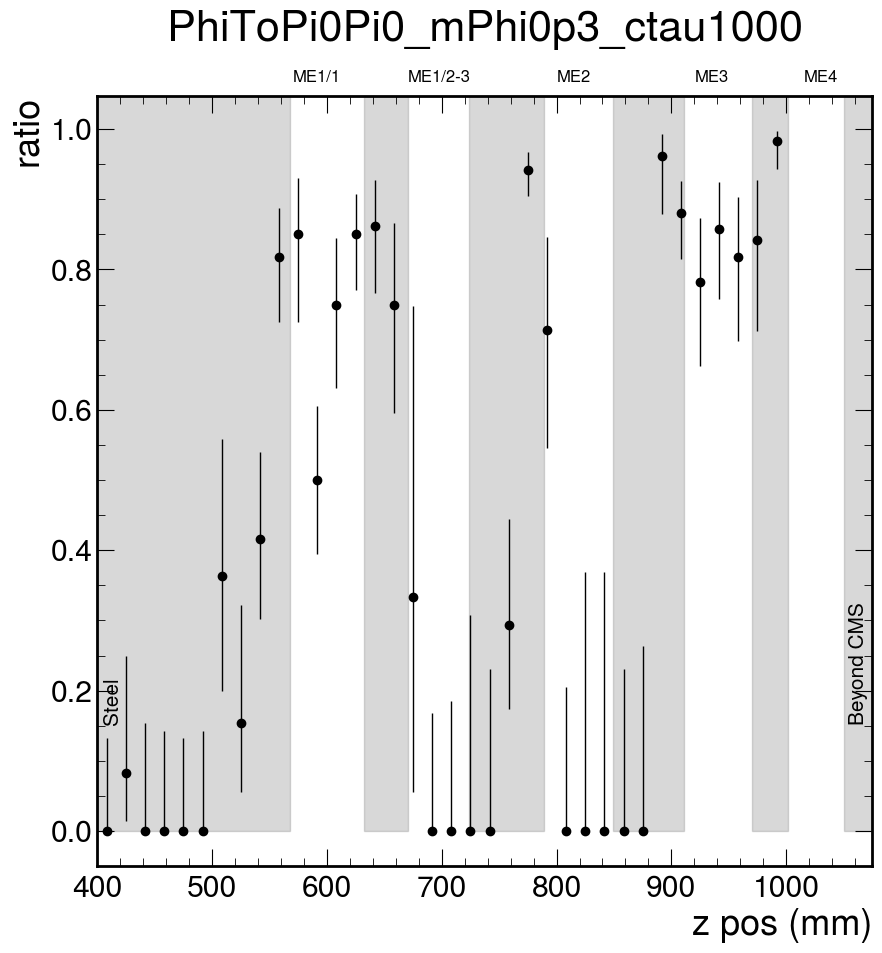

/tmp/ipykernel_29786/3117308672.py:12: RuntimeWarning: invalid value encountered in true_divide
  y=num.view() / den.view() ,


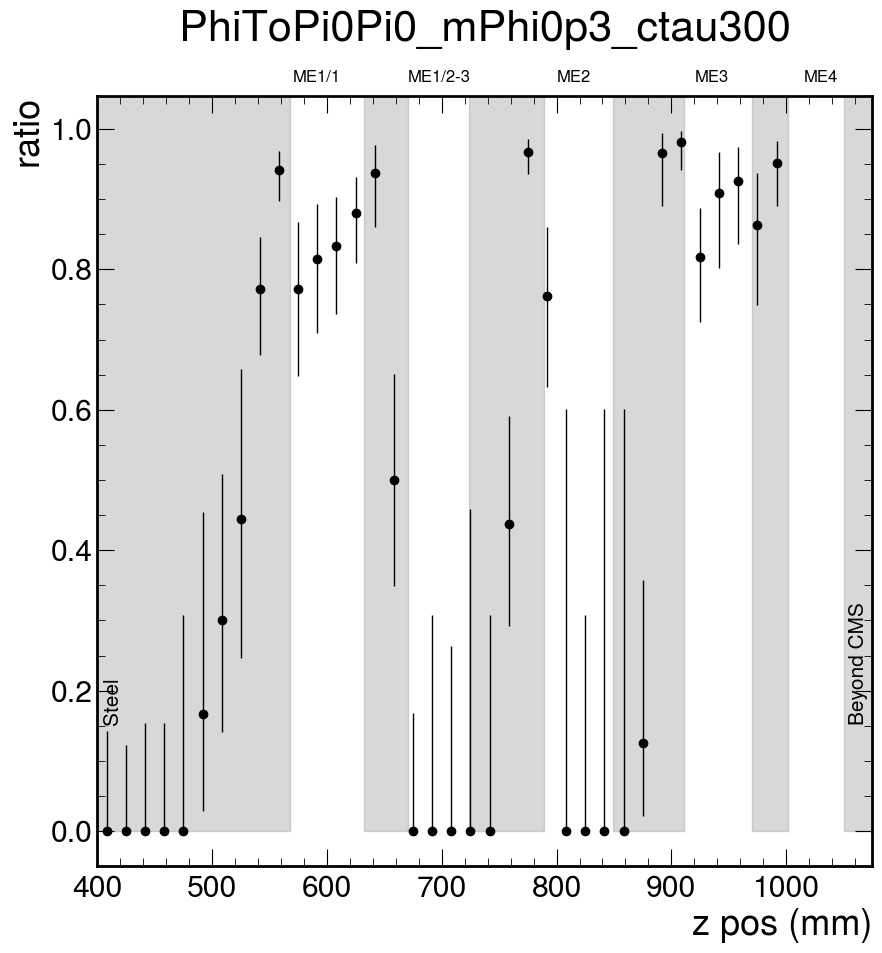

/tmp/ipykernel_29786/3117308672.py:12: RuntimeWarning: invalid value encountered in true_divide
  y=num.view() / den.view() ,


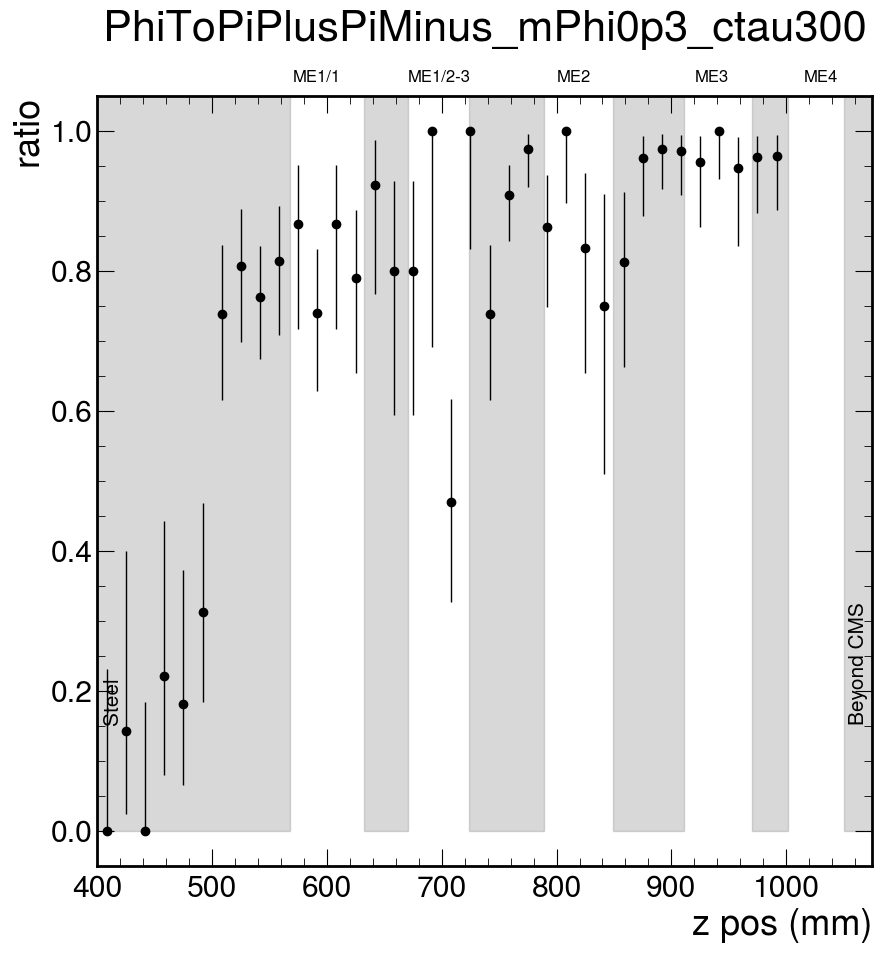

/tmp/ipykernel_29786/3117308672.py:12: RuntimeWarning: invalid value encountered in true_divide
  y=num.view() / den.view() ,


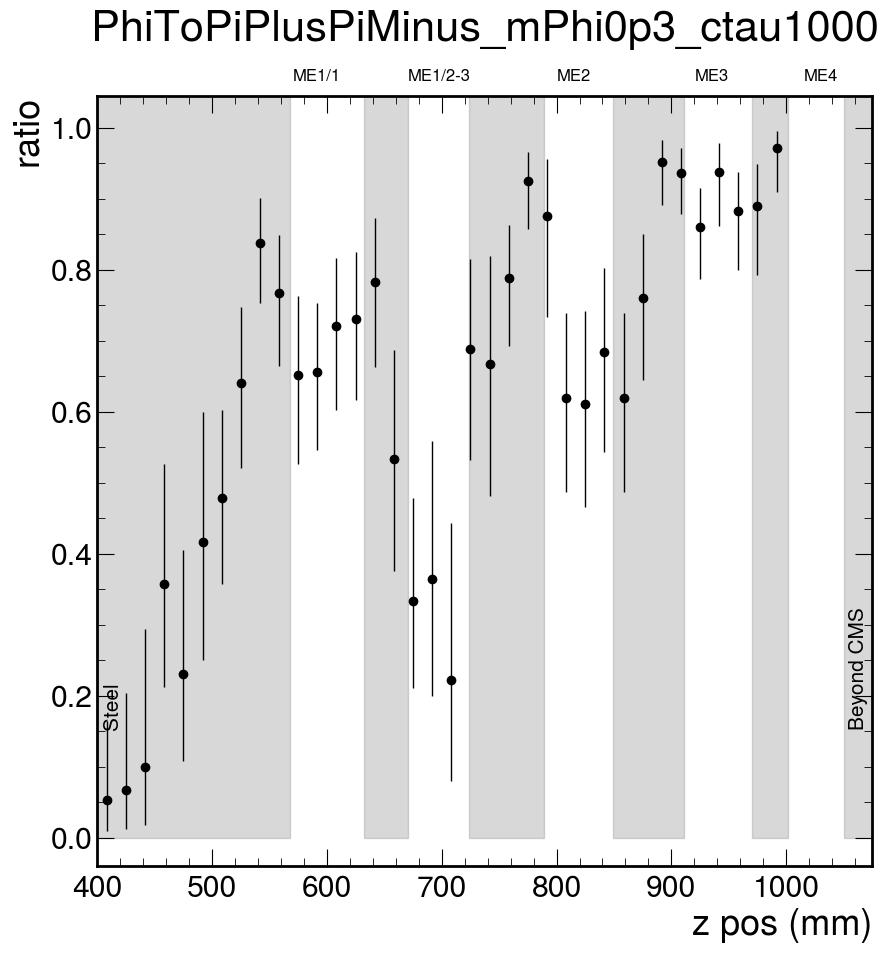

In [12]:
for key in datasets:
    fig, ax = plt.subplots()
    ratio(out[key]['gLLP_decay_vertex_z_matched with in_csc'], out[key]['gLLP_decay_vertex_z with in_csc'], ax)
    drawCSCz(ax)
    ax.set_xlabel("z pos (mm)")
    ax.set_ylabel("ratio")
    ax.set_title(f'{key}\n')
    plt.show()

/tmp/ipykernel_29786/3117308672.py:12: RuntimeWarning: invalid value encountered in true_divide
  y=num.view() / den.view() ,


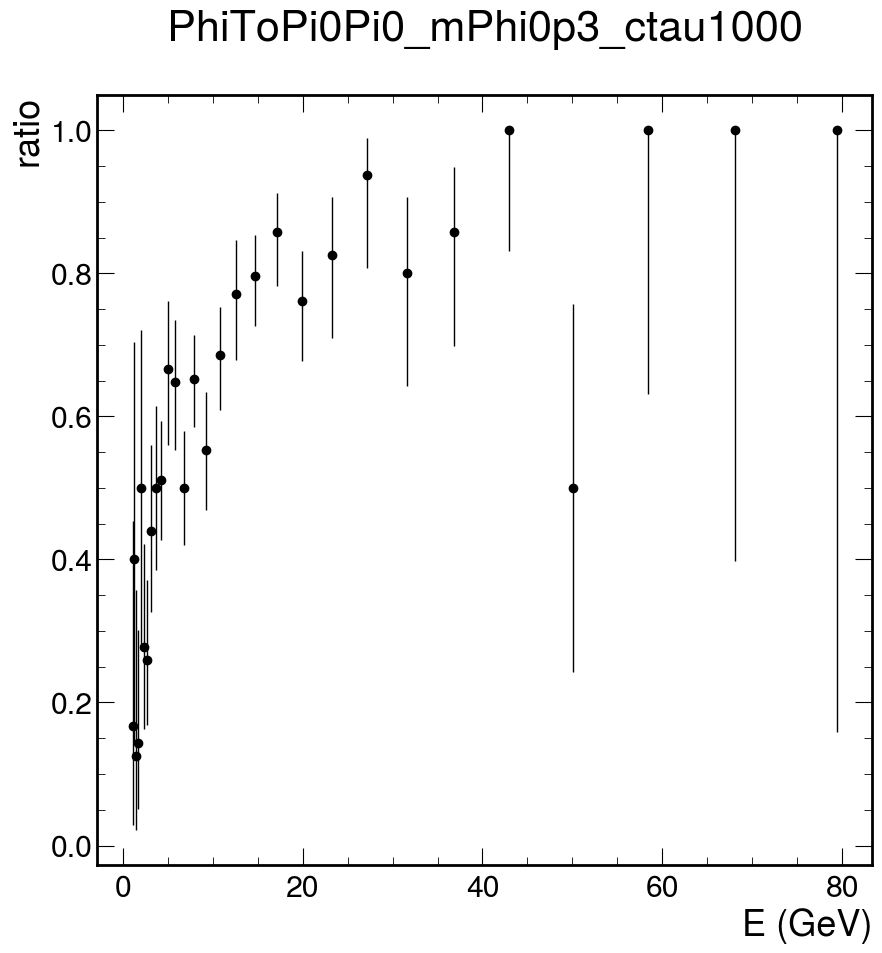

/tmp/ipykernel_29786/3117308672.py:12: RuntimeWarning: invalid value encountered in true_divide
  y=num.view() / den.view() ,


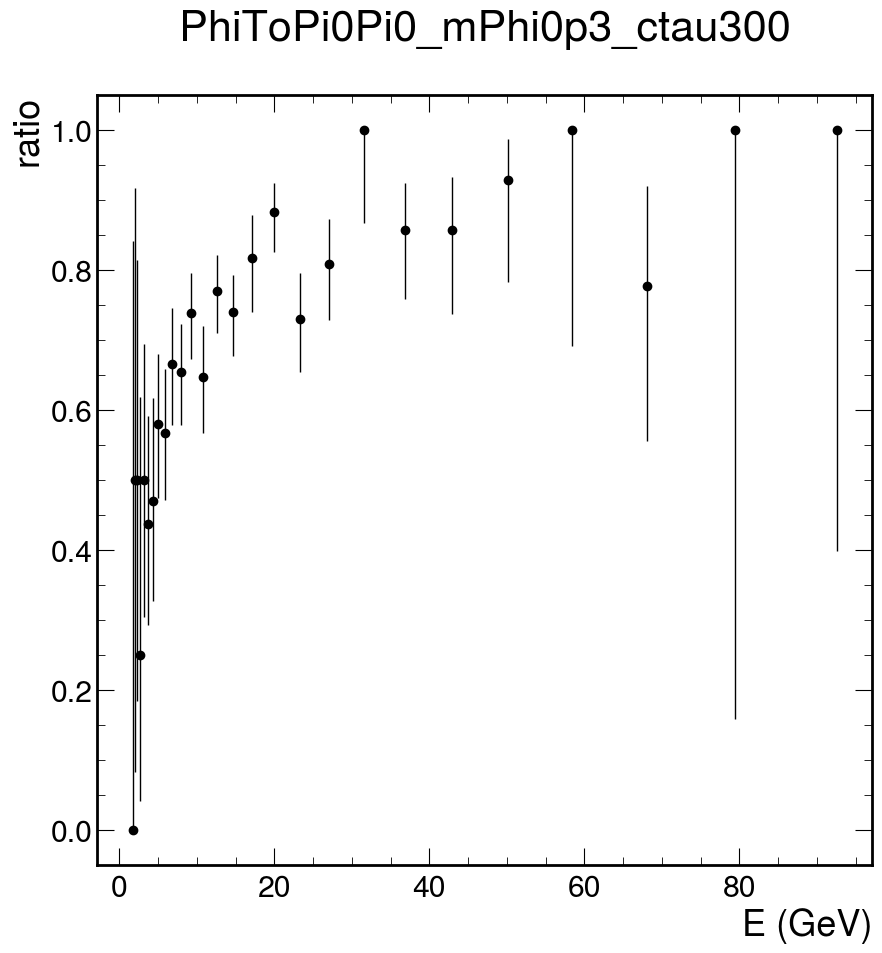

/tmp/ipykernel_29786/3117308672.py:12: RuntimeWarning: invalid value encountered in true_divide
  y=num.view() / den.view() ,


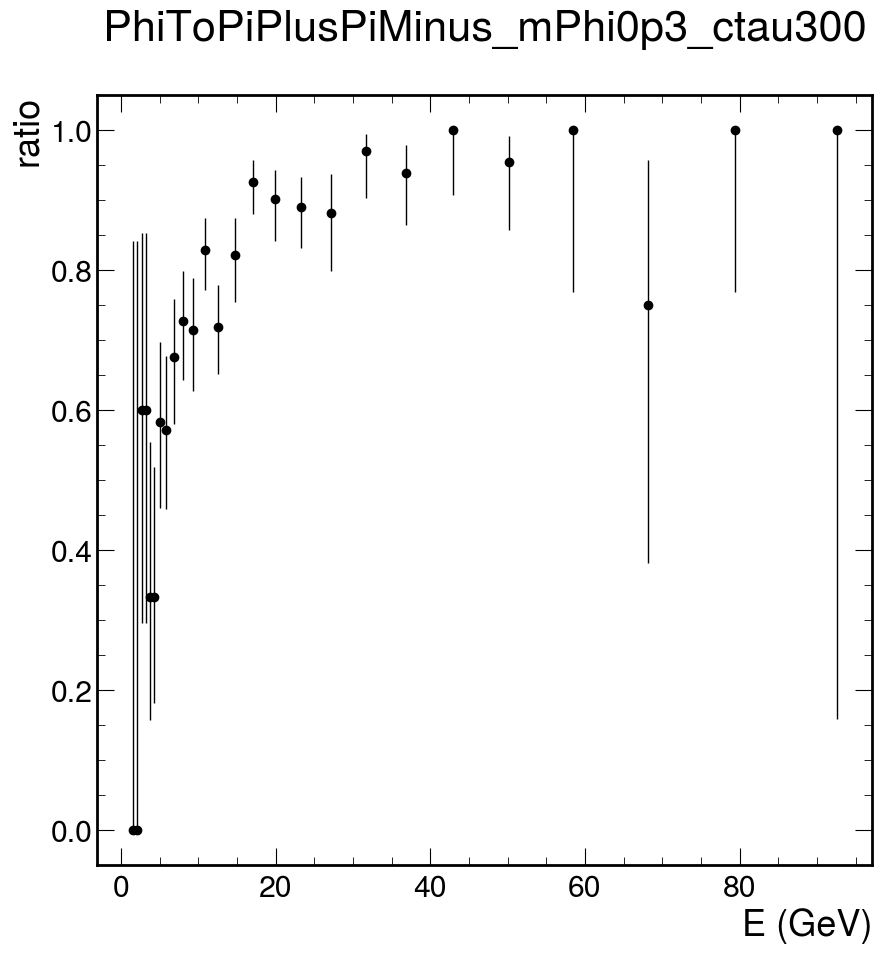

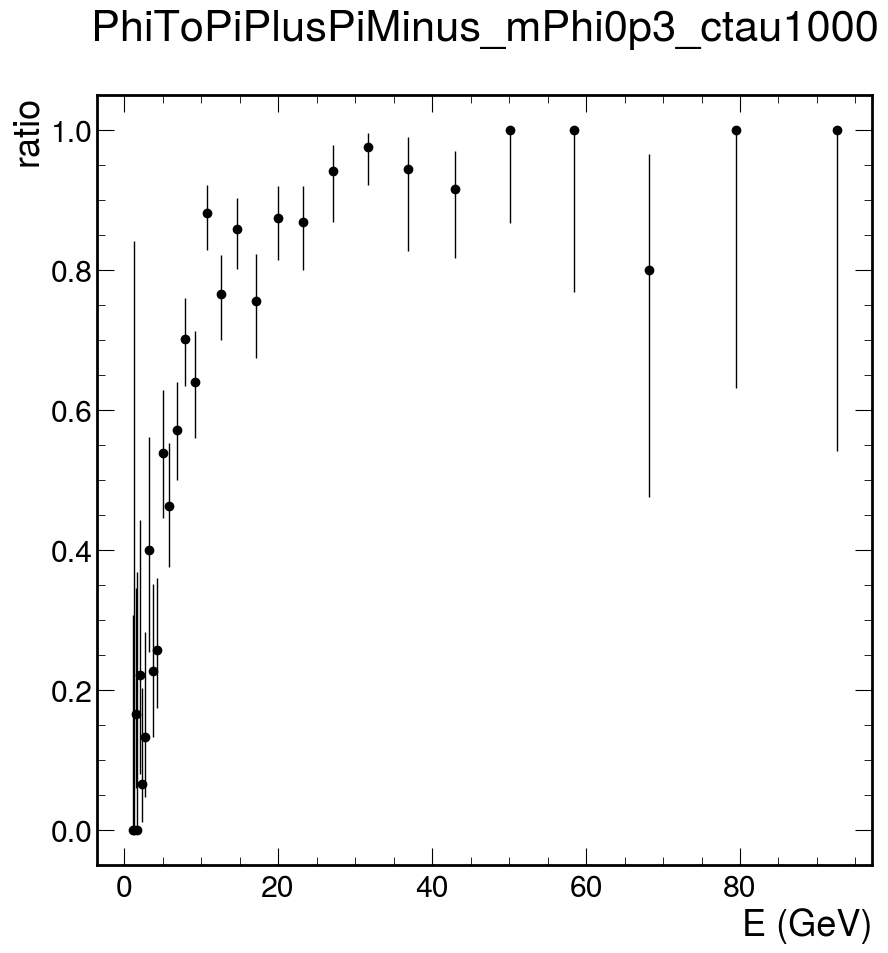

In [50]:
for key in datasets:
    fig, ax = plt.subplots()
    ratio(out[key]['gLLP_e_matched with in_csc'], out[key]['gLLP_e with in_csc'], ax)
    ax.set_xlabel("E (GeV)")
    ax.set_ylabel("ratio")
    ax.set_title(f'{key}\n')
    plt.show()

In [ ]:
from matplotlib.backends.backend_pdf import PdfPages
import warnings

with warnings.catch_warnings(): #i don't need to see all the divide by zero warnings
    warnings.simplefilter("ignore")

    for varname in varnames:
        pdf = PdfPages(f'varPlots_sb_clsCuts_{date}/{varname}_cutflow_sb.pdf')

        for cut in cuts:
            fig, ax = plt.subplots(2,1, gridspec_kw={'height_ratios': [3, 1]}, figsize=(np.sqrt(2)*5,5))

            signal = out['signal'][f'var: {varname} with cut: {cut}']
            background = out['background'][f'var: {varname} with cut: {cut}']

            hep.histplot(signal/signal.sum(), label='signal', ax=ax[0])
            hep.histplot(background/background.sum(), label='background', ax=ax[0])
            ax[0].set_title(f'{varname} with {cut} cut')
            ax[0].legend()
            ax[0].tick_params(
                axis='x',          # changes apply to the x-axis
                which='both',      # both major and minor ticks are affected
                bottom=False,      # ticks along the bottom edge are off
                top=False,         # ticks along the top edge are off
                labelbottom=False) # labels along the bottom edge are off
            ax[0].set(xlabel=None)
            ax[0].set_yscale('log')

            ratio(signal/signal.sum(), background/background.sum(), ax[1])
            ax[1].set_xlim(ax[0].get_xlim())
            ax[1].set(xlabel=varname)
            ax[1].set_yscale('log')
            fig.subplots_adjust(wspace=0, hspace=.05)
            pdf.savefig(fig)
            print(f'var: {varname} with cut: {cut} saved in a pdf')
        pdf.close()


In [70]:
def ratio(num, den, ax):
    ax.errorbar(
        x=num.axes[0].centers,
        y=num.view() / den.view() ,
        yerr=ratio_uncertainty(num.view(), den.view()),
        color="k",
        linestyle="none",
        marker="o",
        elinewidth=1,
    )
    return ax

def sb_plotter(varname, cut):
    fig, ax = plt.subplots(2,1, gridspec_kw={'height_ratios': [3, 1]}, figsize=(np.sqrt(2)*5,5))

    signal = out['signal'][f'{varname} with {cut}']
    background = out['background'][f'{varname} with {cut}']

        
    hep.histplot(signal/signal.sum(), label='signal', ax=ax[0])
    hep.histplot(background/background.sum(), label='background', ax=ax[0])
    ax[0].set_title(f'{varname} with {cut}')
    ax[0].legend()
    ax[0].tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=False) # labels along the bottom edge are off
    ax[0].set(xlabel=None)
    ax[0].set_yscale('log')

    ratio(signal/signal.sum(), background/background.sum(), ax[1])
    ax[1].set_xlim(ax[0].get_xlim())
    #ax[1].set_ylim((0,2))
    ax[1].set(xlabel=varname)
    ax[1].set_yscale('log')
    #fig.subplots_adjust(wspace=0, hspace=.05)
    return fig

def sb_plotter_noratio(varname, cut, ax):
    signal = out['signal'][f'{varname} with {cut}']
    background = out['background'][f'{varname} with {cut}']

        
    hep.histplot(signal/signal.sum(), label='signal', ax=ax)
    hep.histplot(background/background.sum(), label='background', ax=ax)
    ax.set_title(f'{varname} with {cut}')
    ax.legend()
    # ax.tick_params(
    #     axis='x',          # changes apply to the x-axis
    #     which='both',      # both major and minor ticks are affected
    #     bottom=False,      # ticks along the bottom edge are off
    #     top=False,         # ticks along the top edge are off
    #     labelbottom=False) # labels along the bottom edge are off
    #ax.set(xlabel=None)
    ax.set_yscale('log')

/tmp/ipykernel_11128/2248855530.py:4: RuntimeWarning: invalid value encountered in true_divide
  y=num.view() / den.view() ,
/tmp/ipykernel_11128/2248855530.py:4: RuntimeWarning: invalid value encountered in true_divide
  y=num.view() / den.view() ,
/tmp/ipykernel_11128/2248855530.py:4: RuntimeWarning: invalid value encountered in true_divide
  y=num.view() / den.view() ,
/tmp/ipykernel_11128/2248855530.py:4: RuntimeWarning: invalid value encountered in true_divide
  y=num.view() / den.view() ,
/tmp/ipykernel_11128/2248855530.py:4: RuntimeWarning: invalid value encountered in true_divide
  y=num.view() / den.view() ,
/tmp/ipykernel_11128/2248855530.py:4: RuntimeWarning: invalid value encountered in true_divide
  y=num.view() / den.view() ,
/tmp/ipykernel_11128/2248855530.py:4: RuntimeWarning: invalid value encountered in true_divide
  y=num.view() / den.view() ,
/tmp/ipykernel_11128/2248855530.py:4: RuntimeWarning: invalid value encountered in true_divide
  y=num.view() / den.view() ,


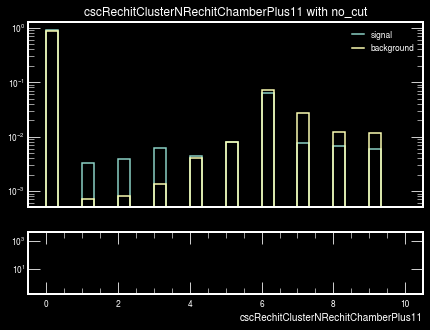

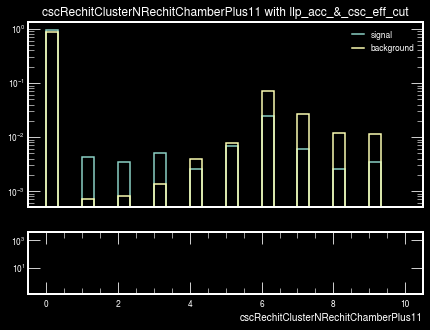

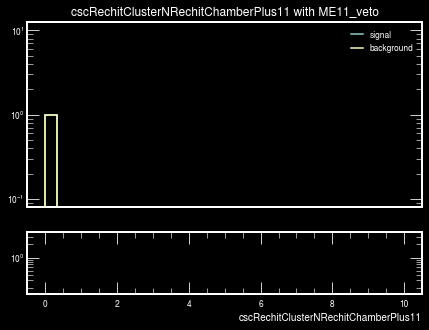

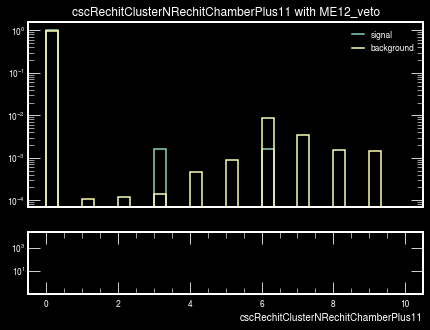

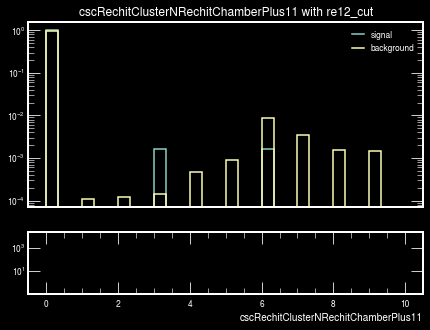

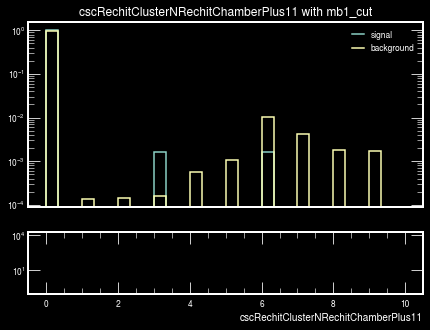

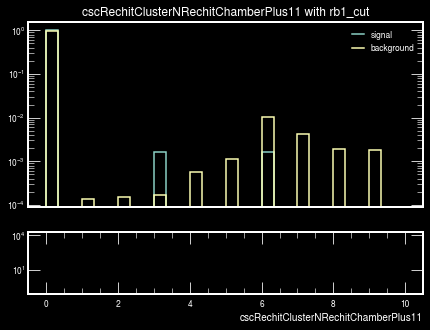

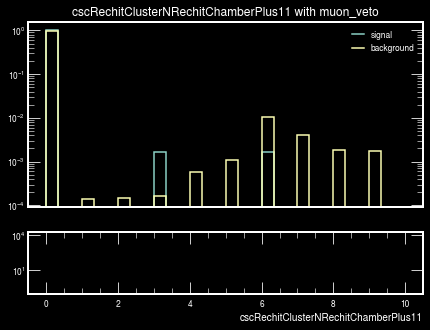

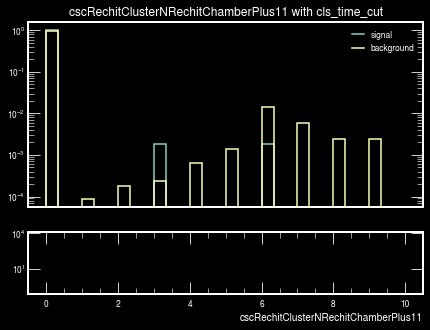

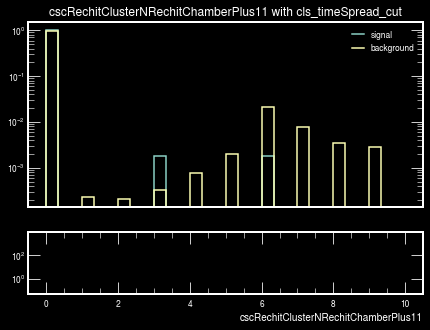

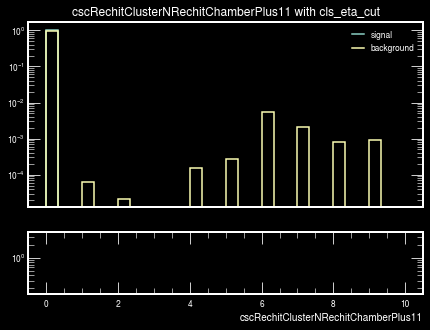

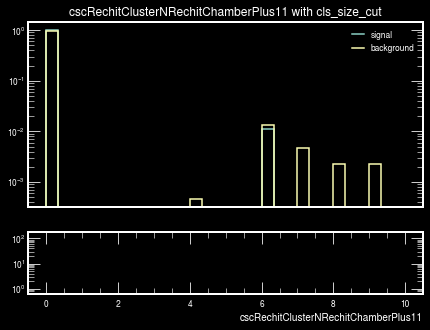

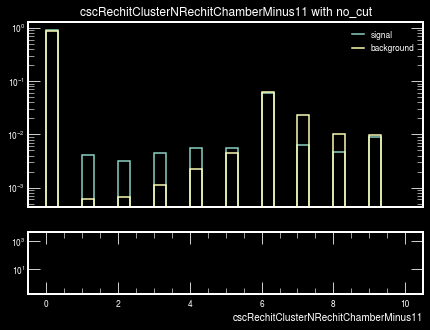

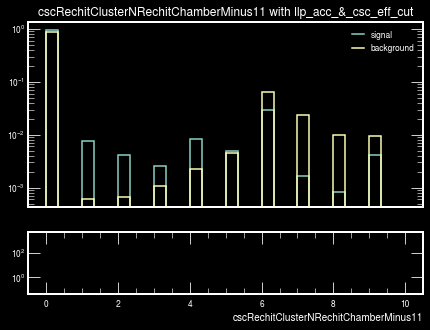

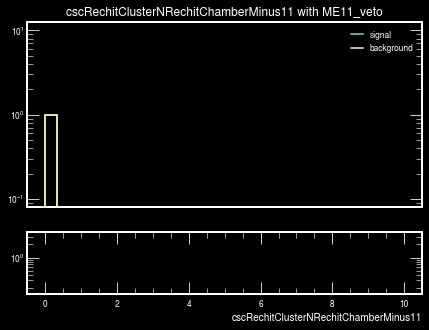

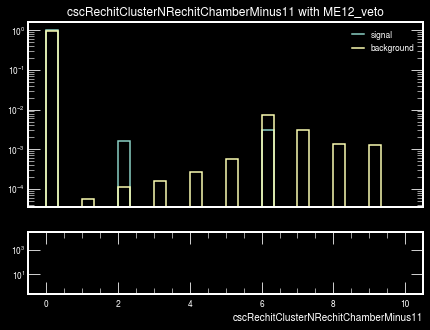

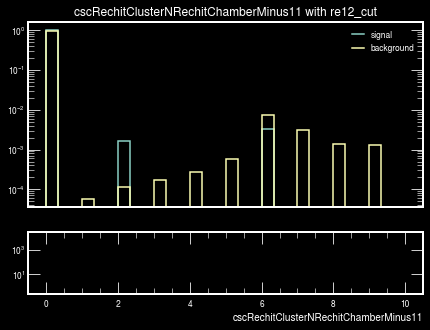

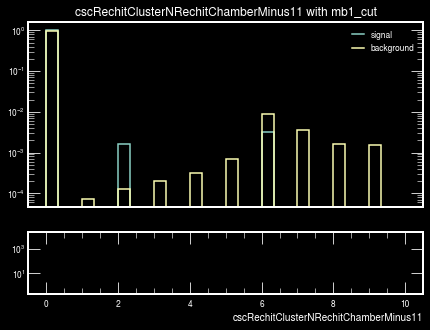

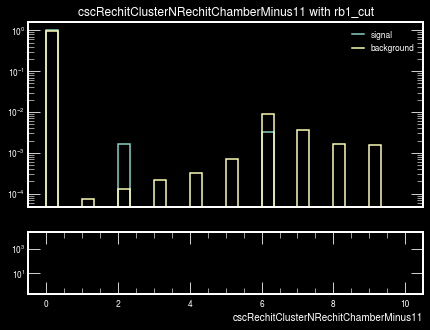

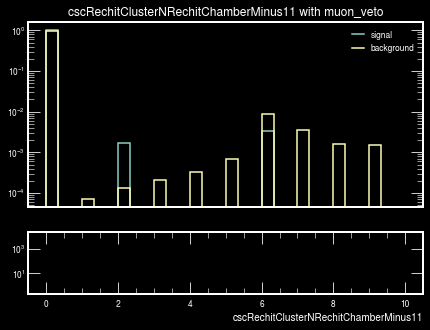

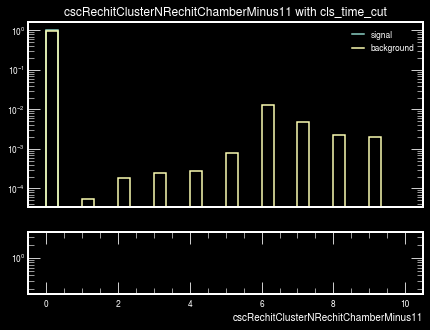

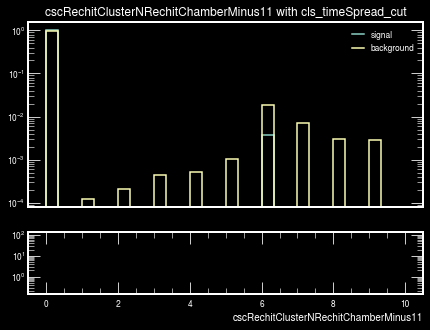

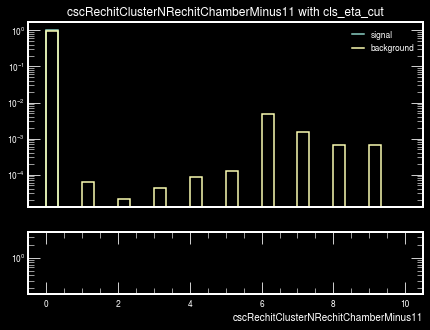

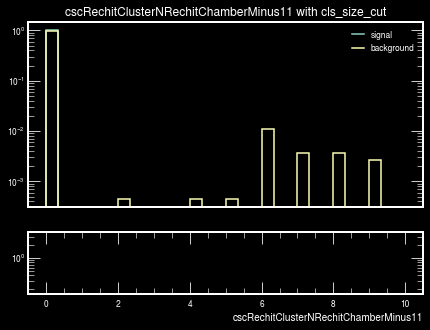

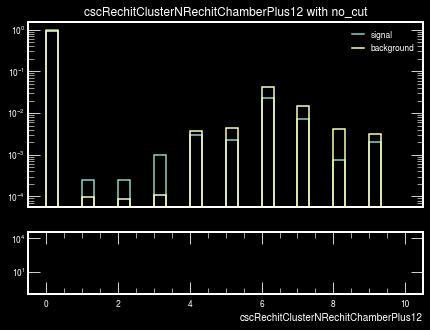

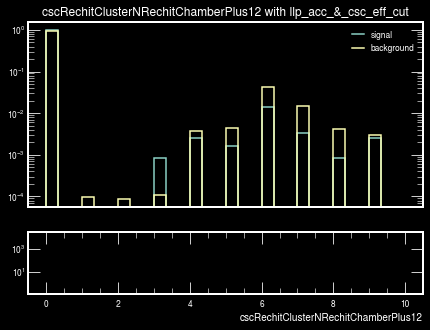

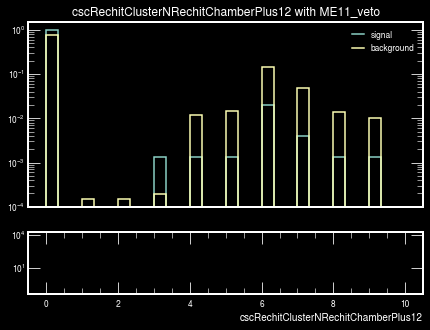

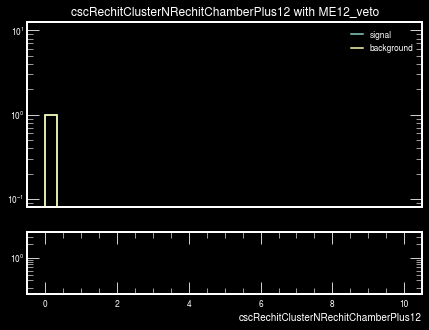

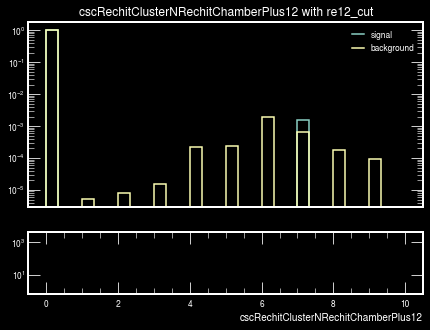

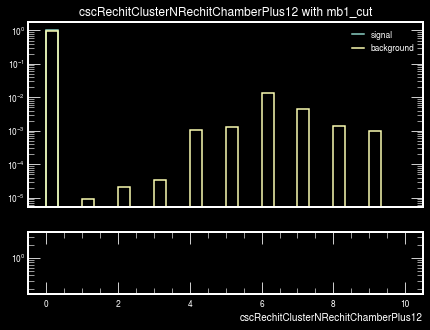

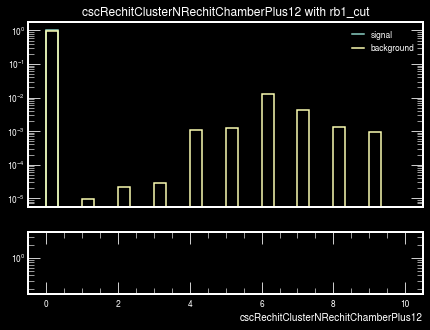

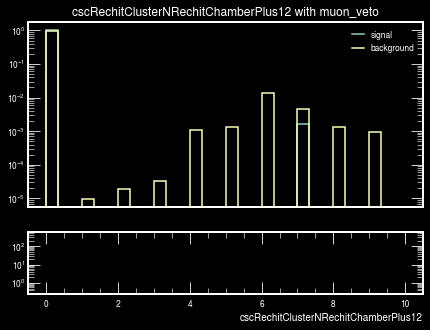

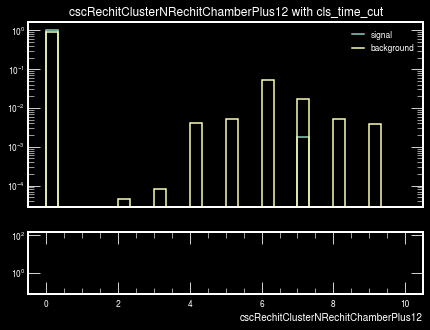

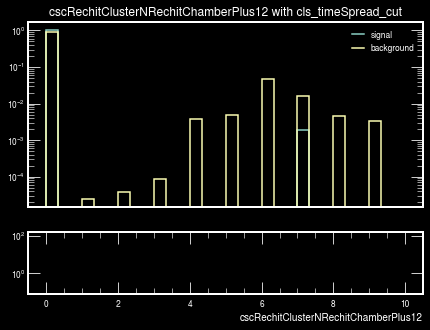

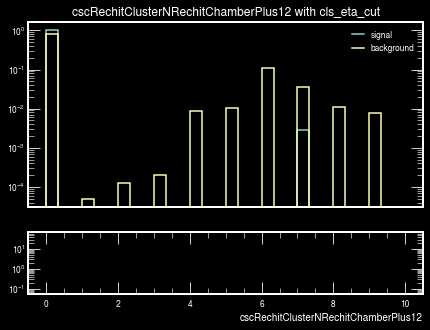

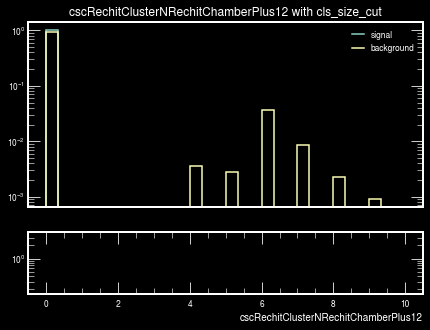

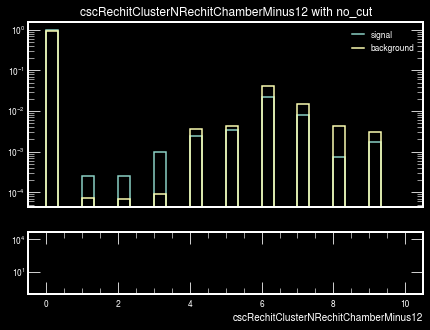

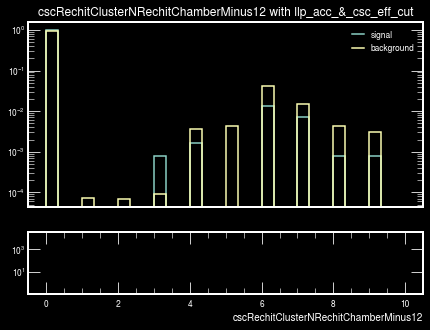

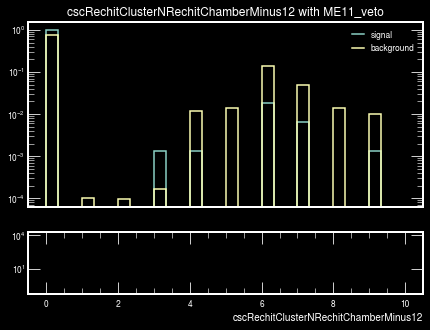

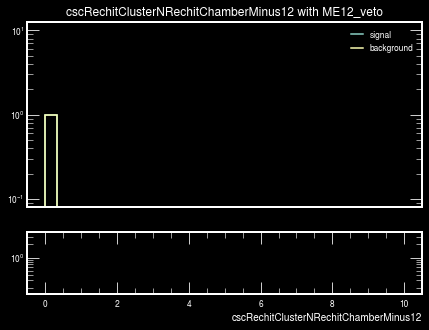

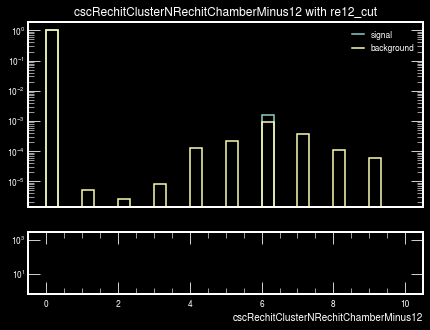

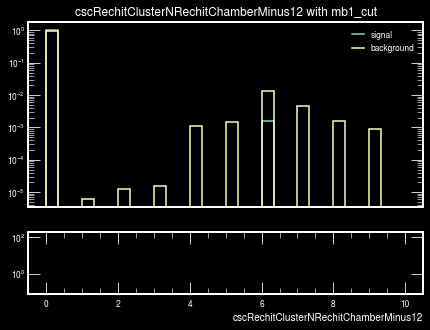

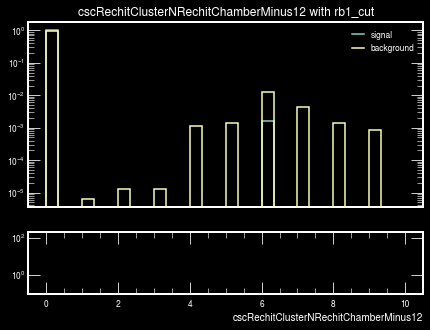

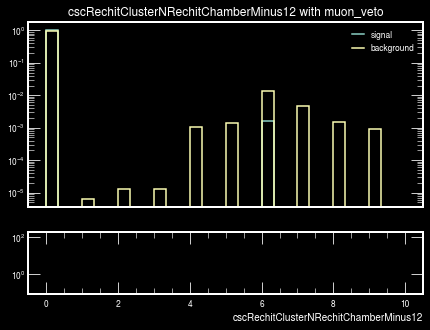

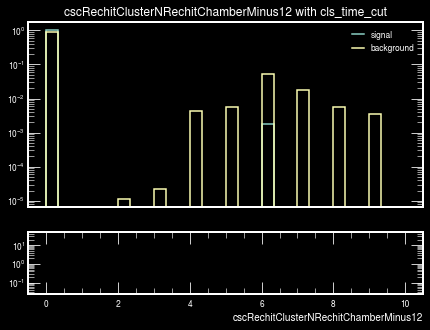

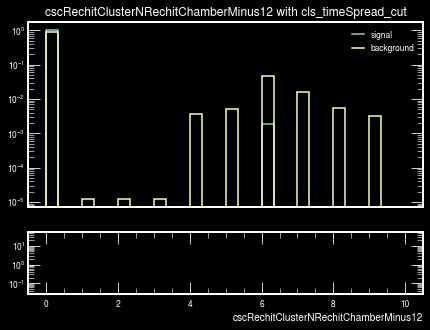

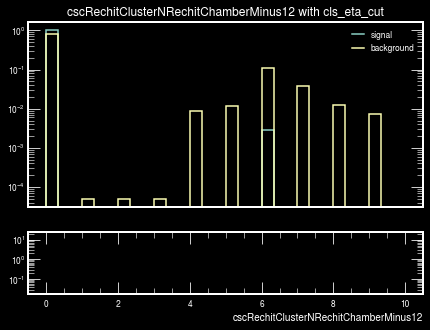

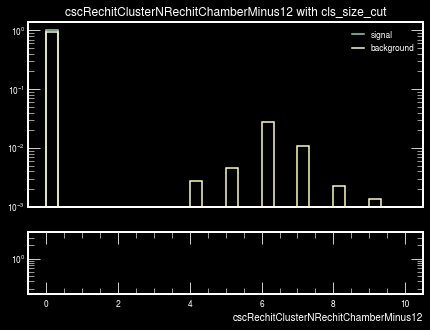

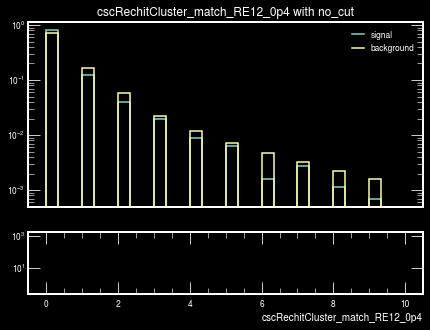

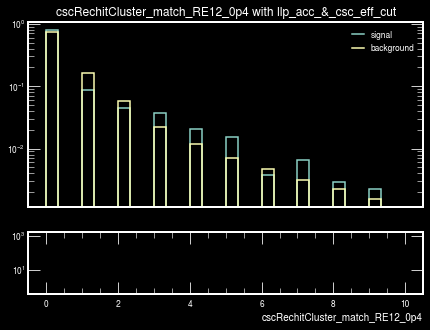

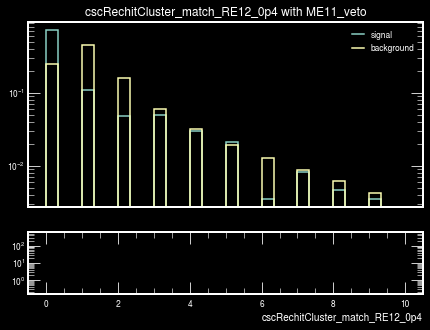

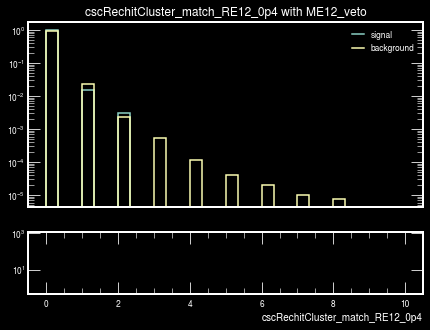

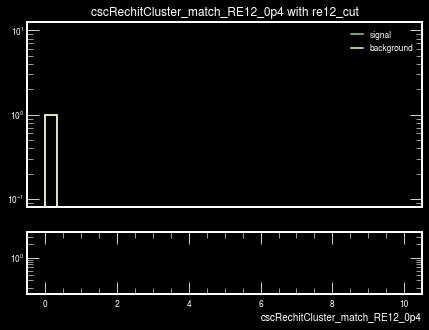

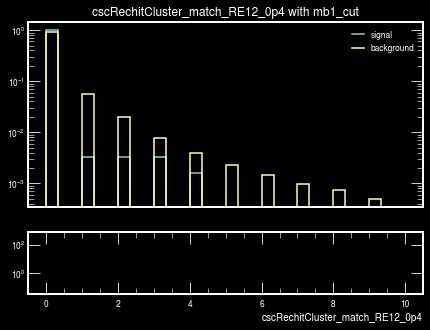

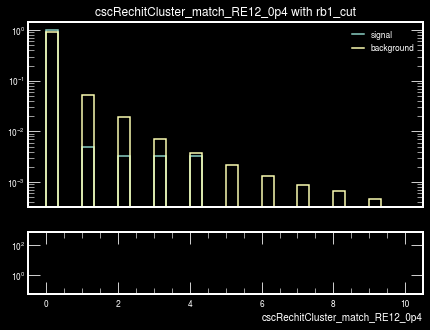

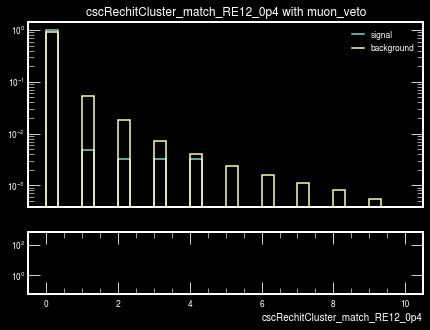

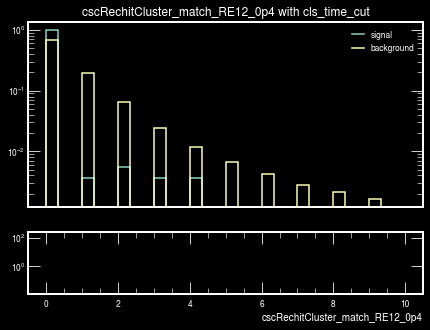

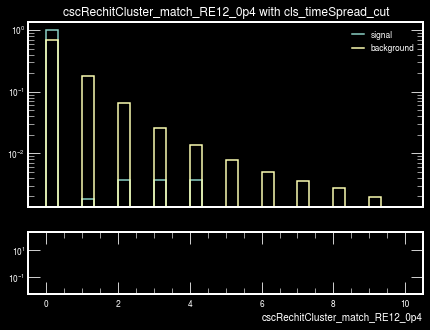

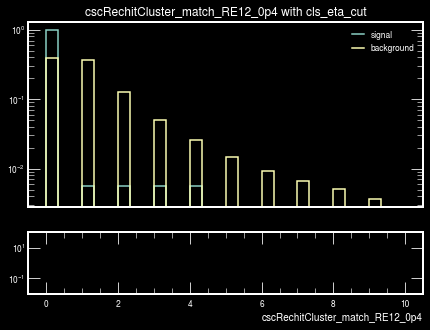

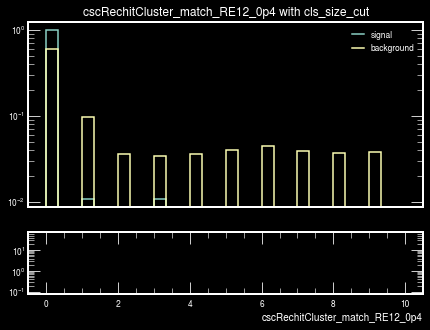

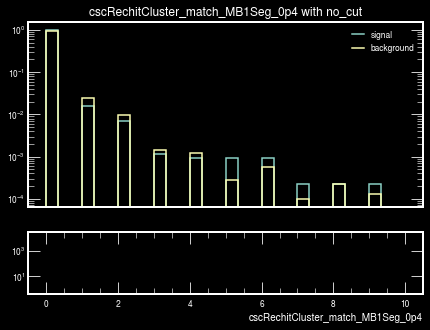

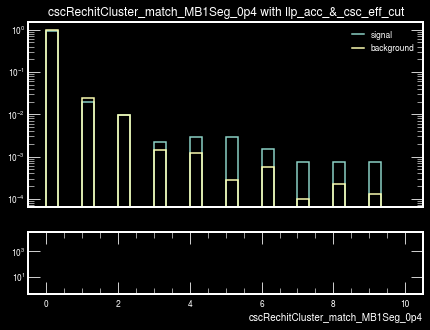

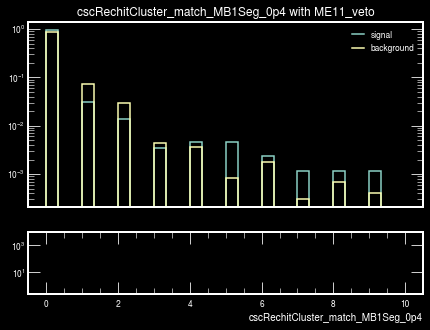

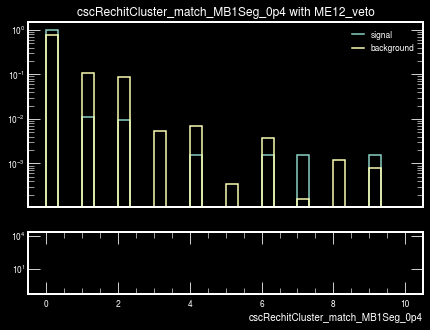

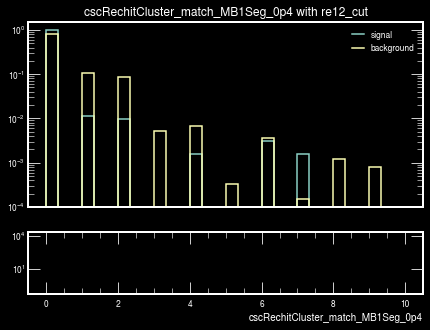

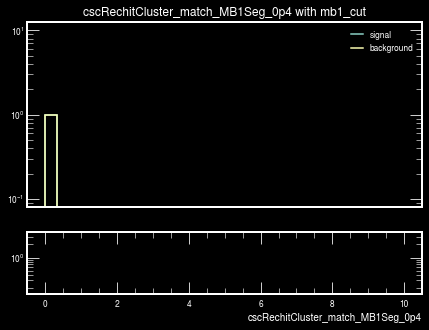

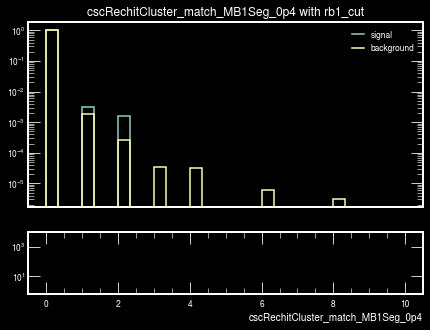

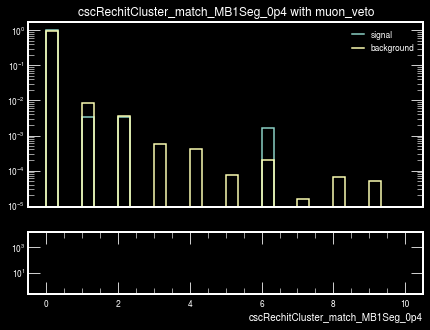

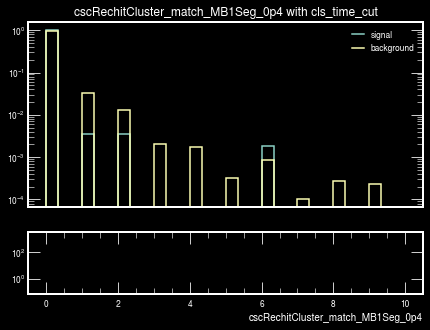

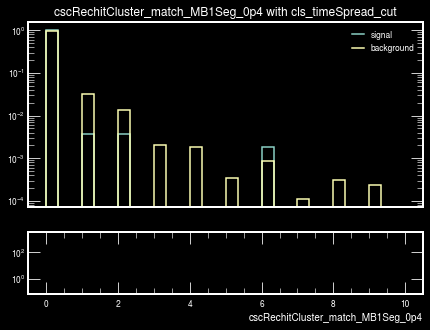

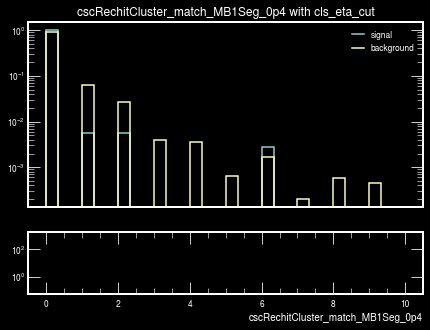

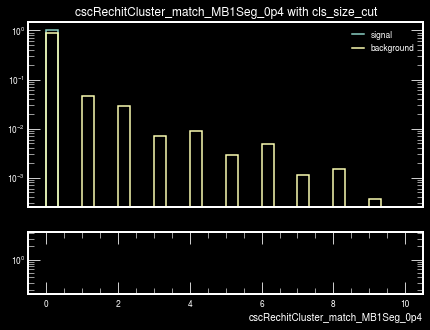

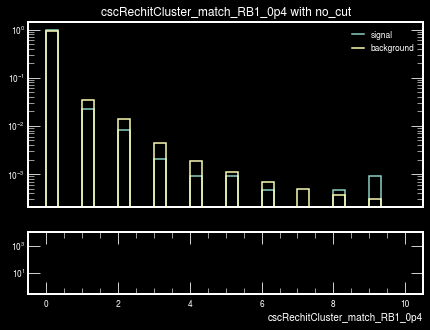

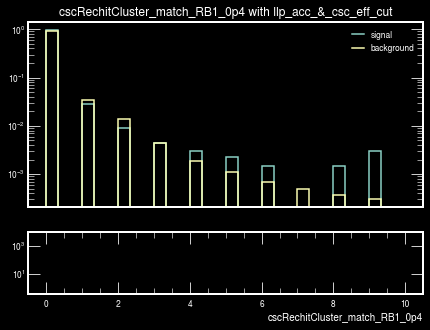

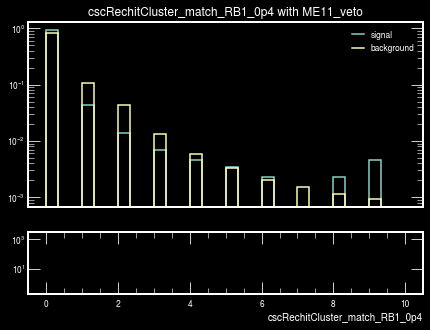

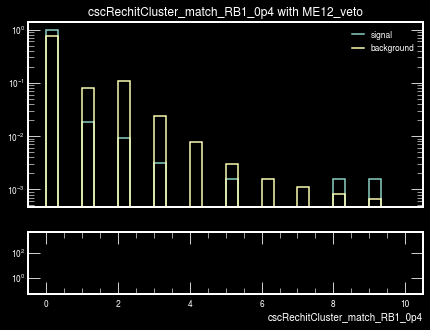

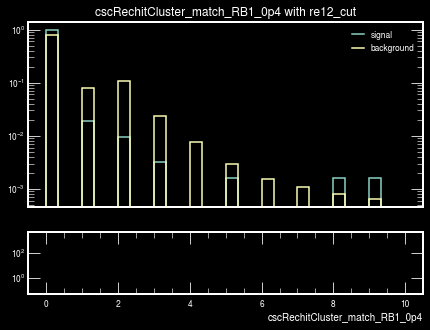

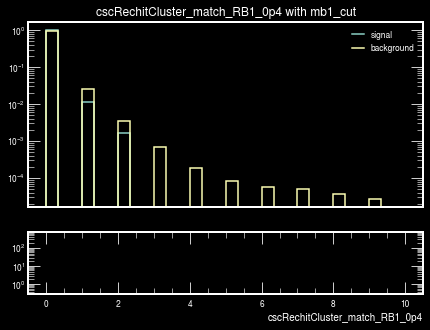

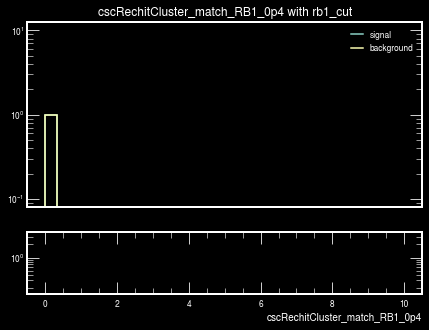

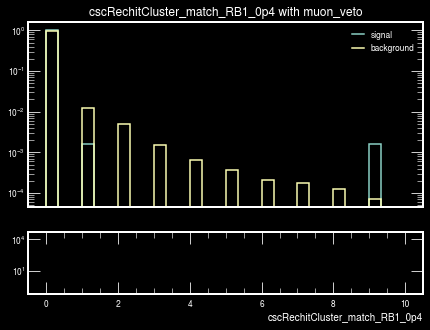

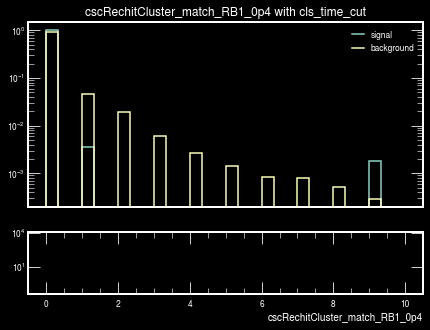

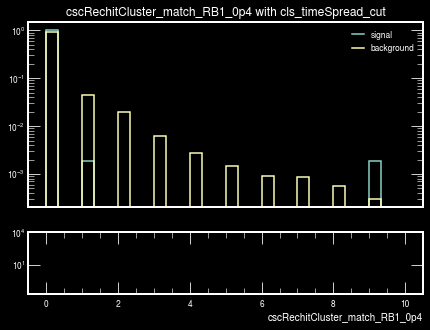

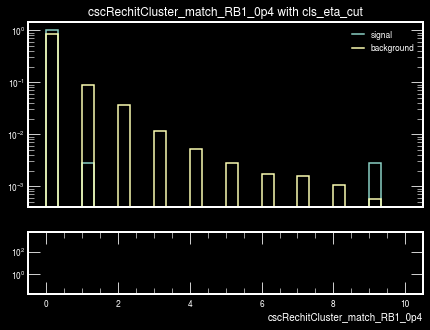

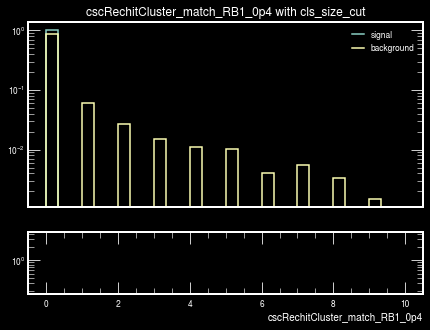

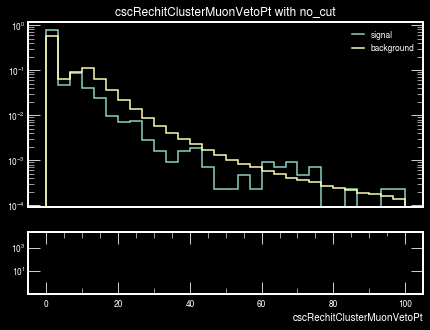

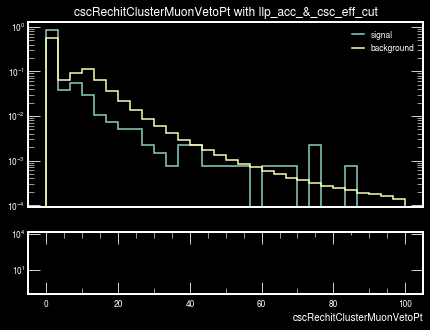

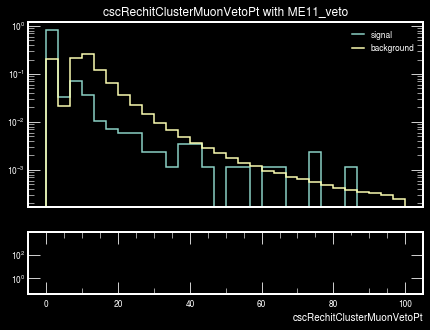

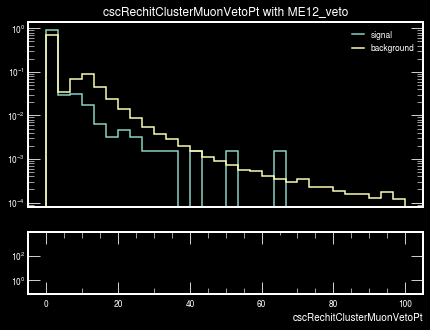

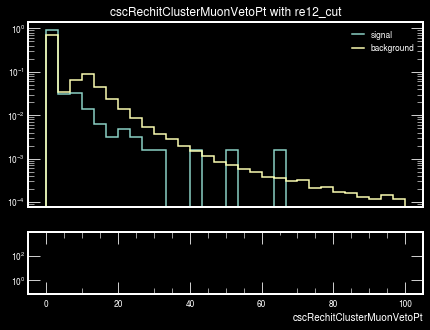

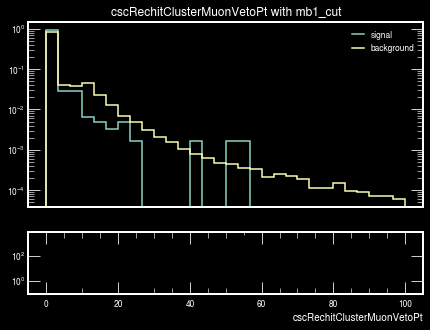

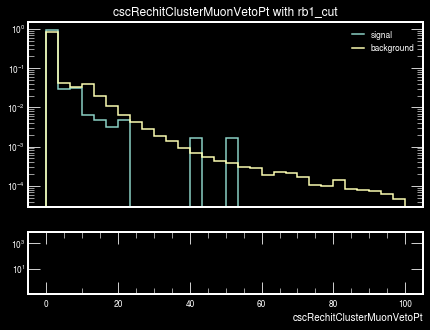

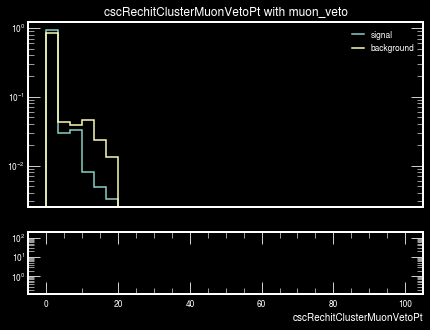

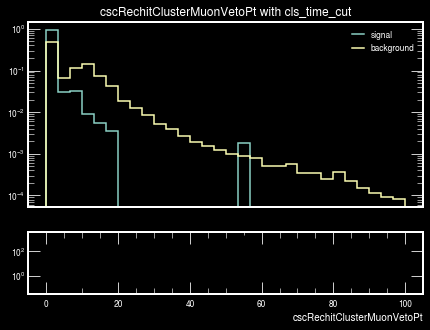

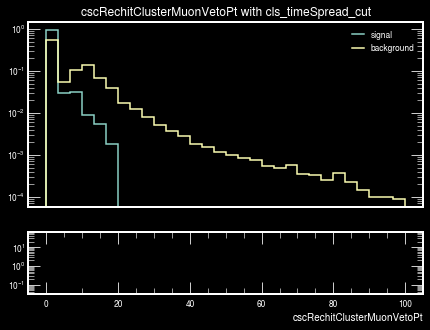

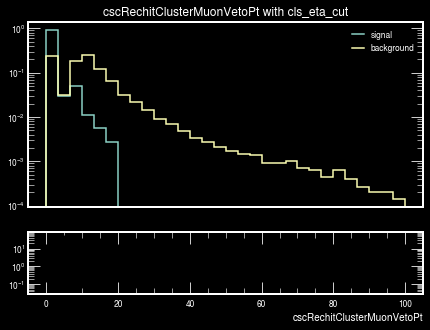

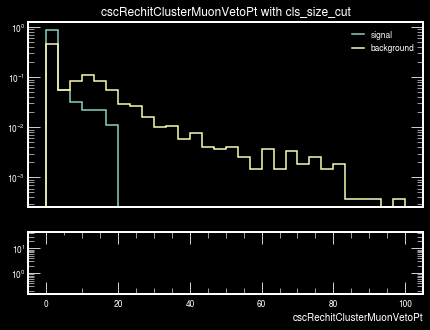

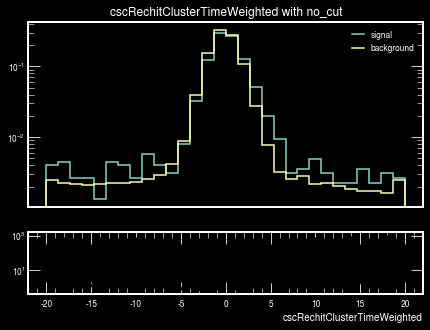

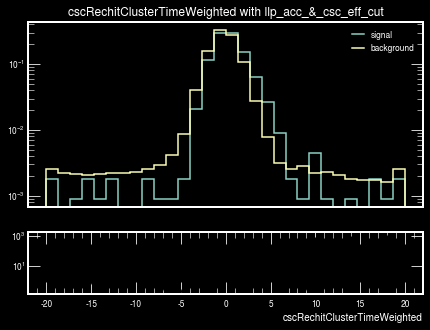

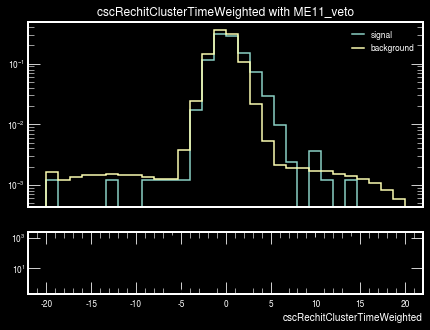

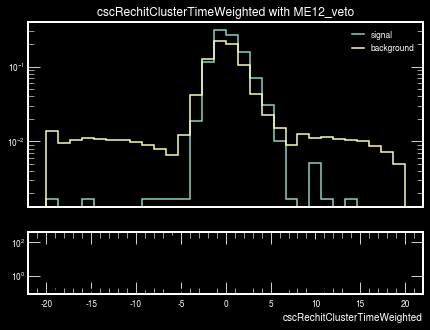

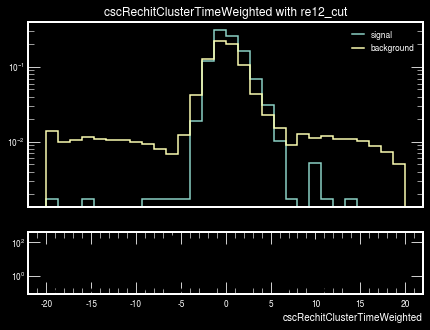

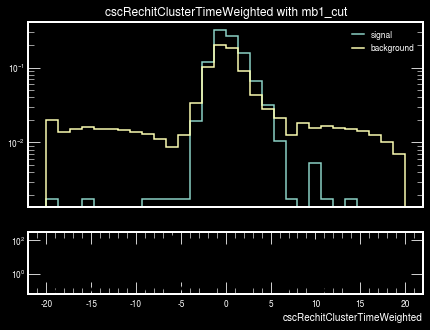

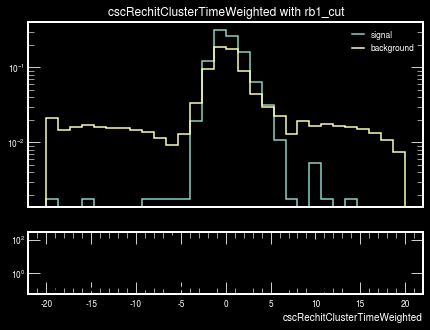

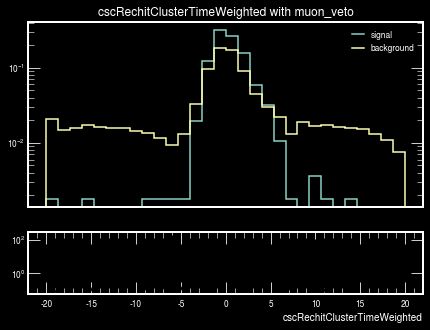

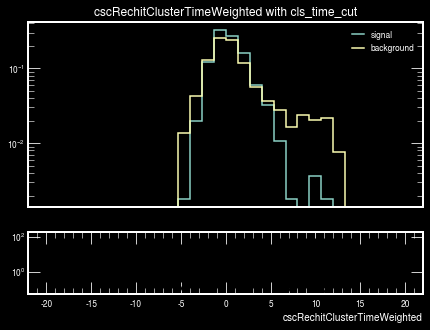

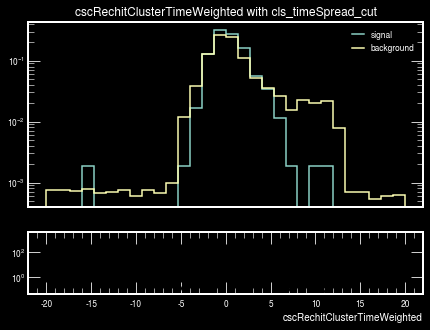

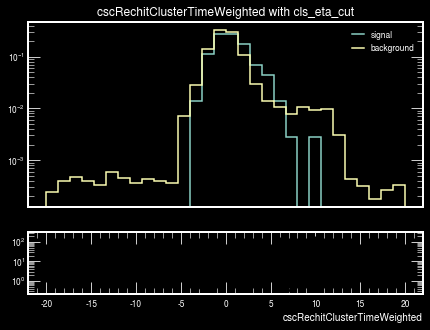

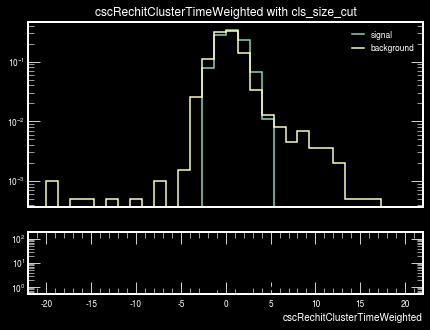

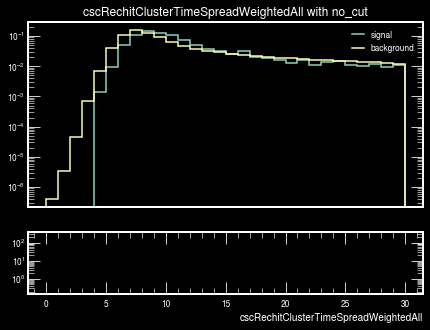

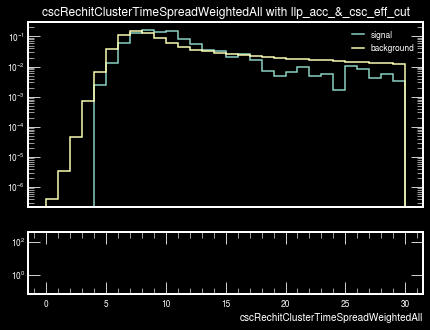

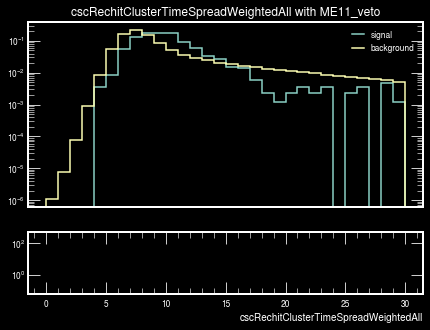

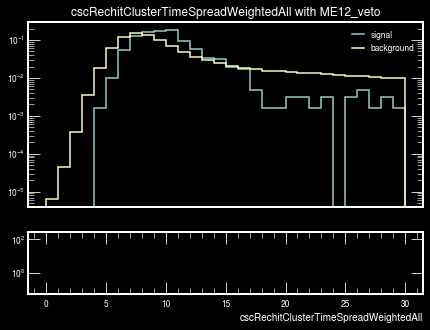

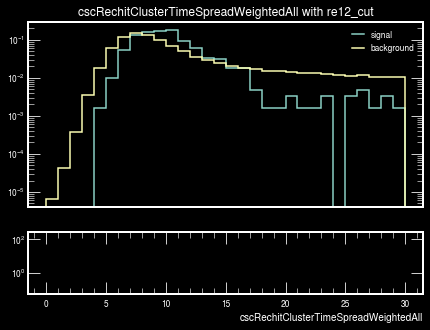

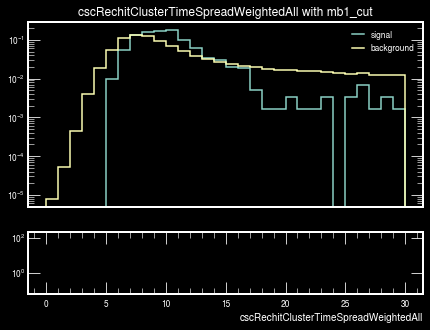

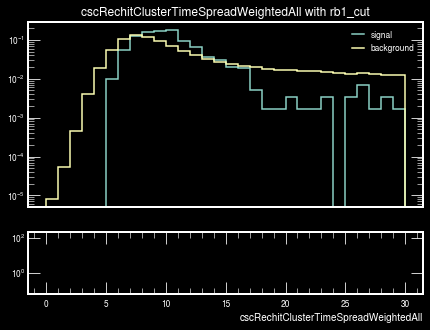

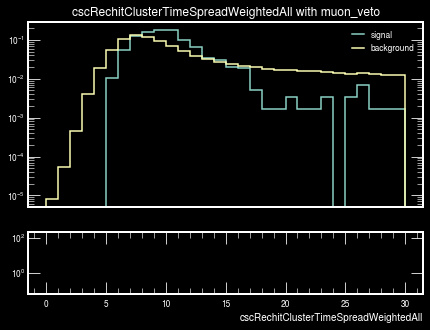

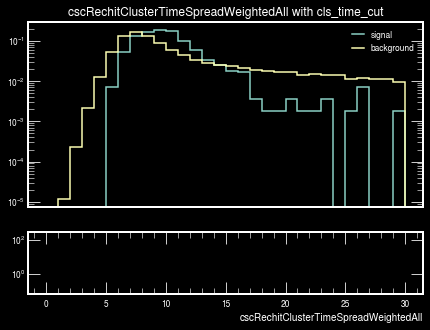

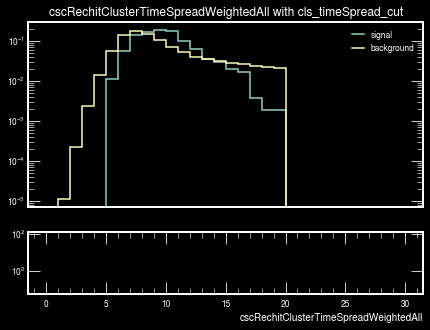

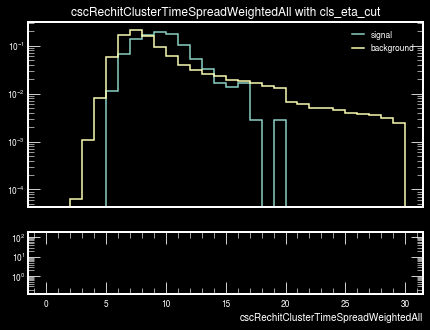

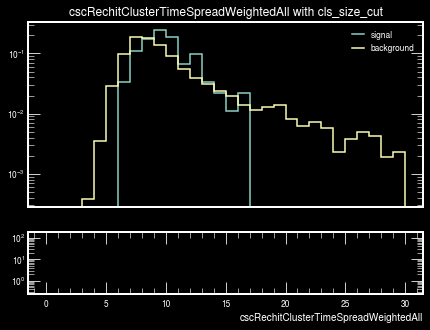

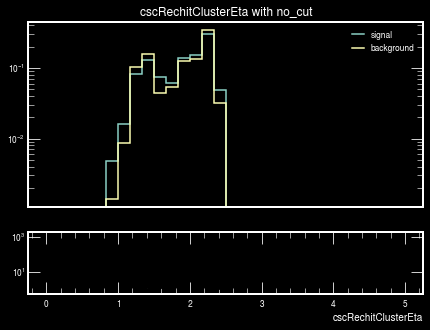

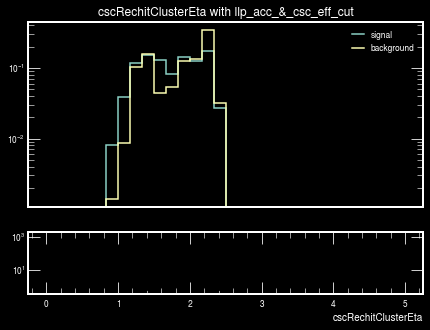

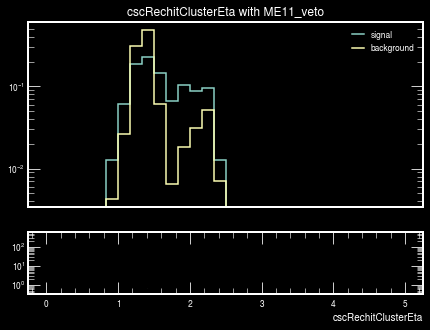

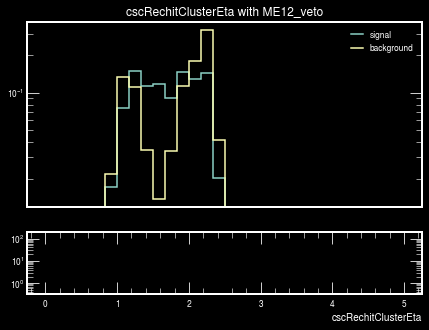

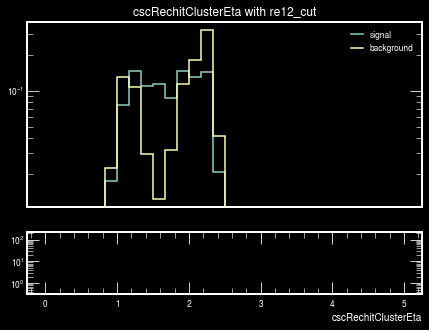

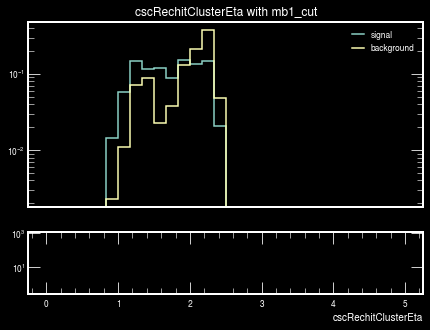

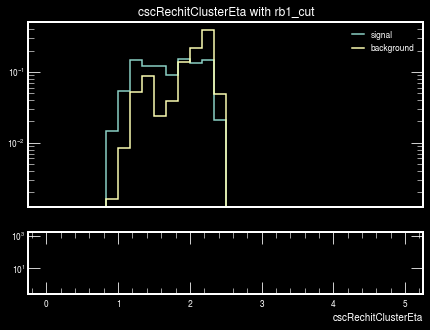

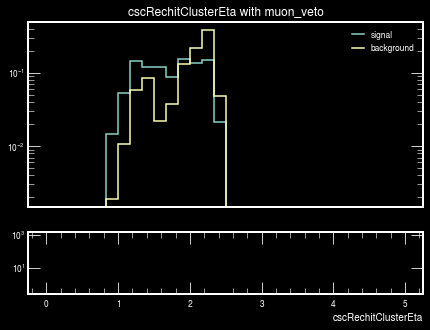

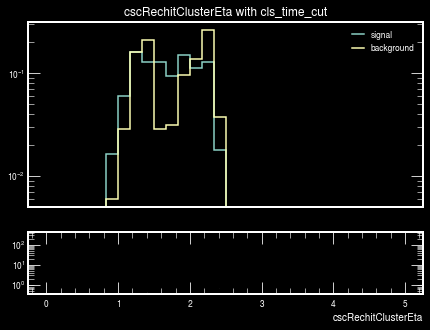

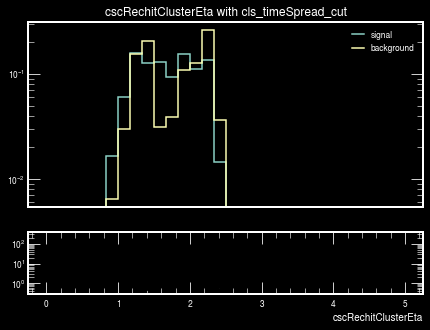

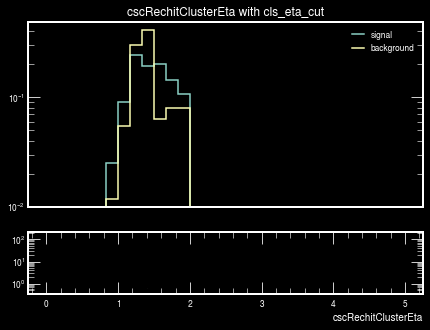

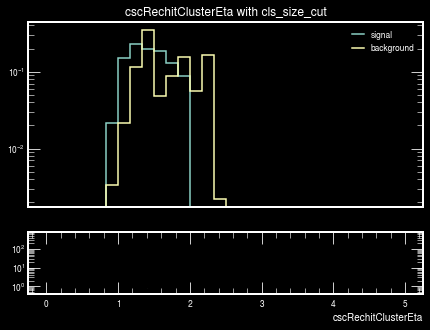

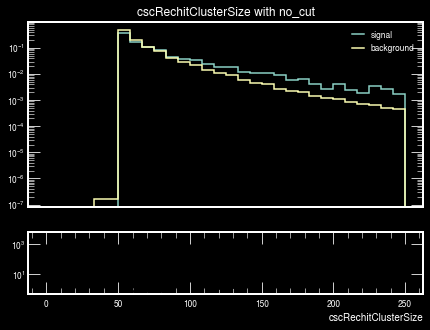

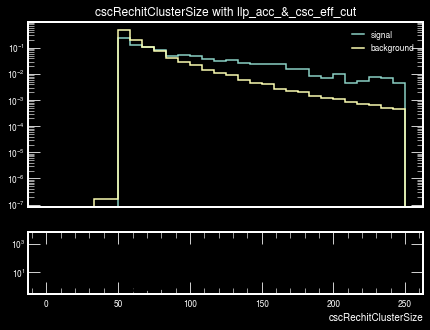

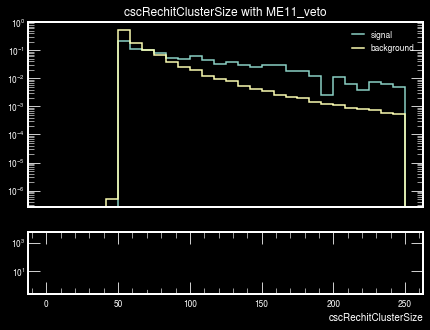

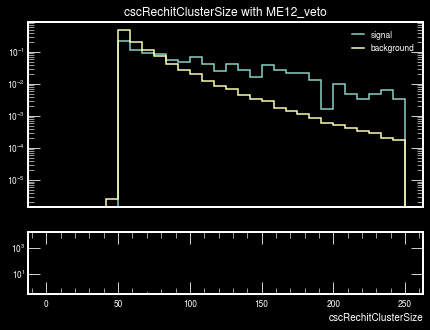

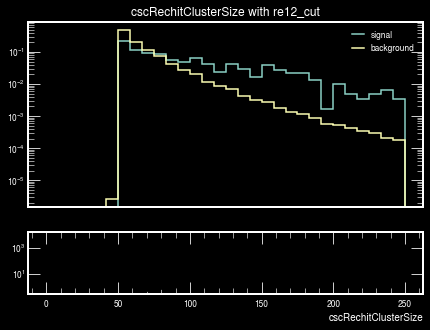

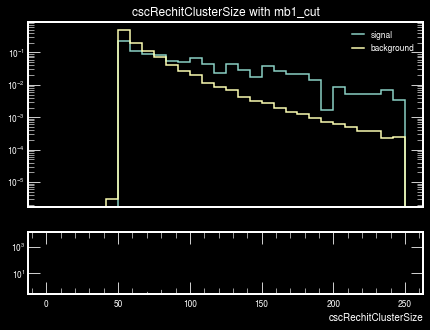

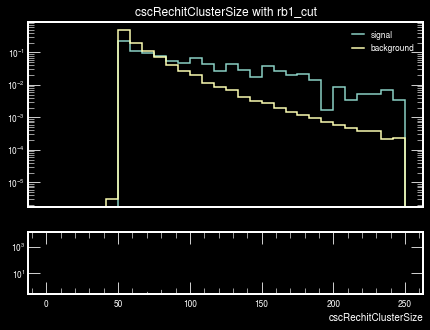

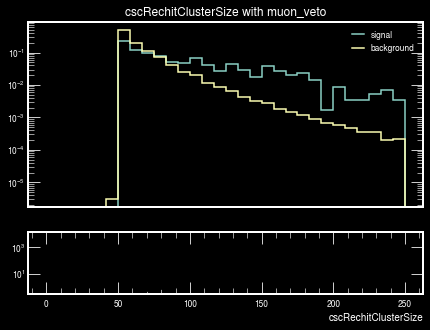

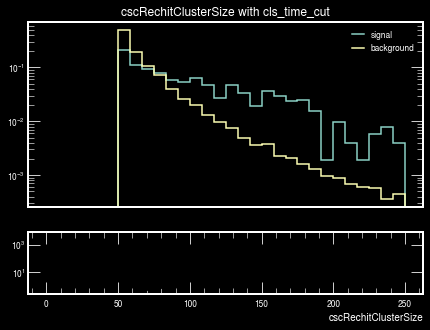

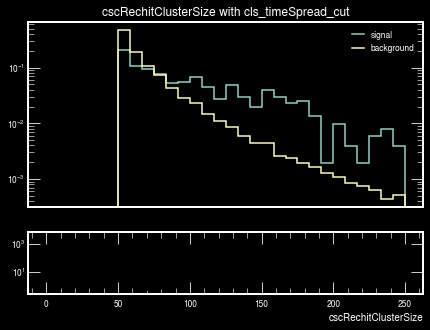

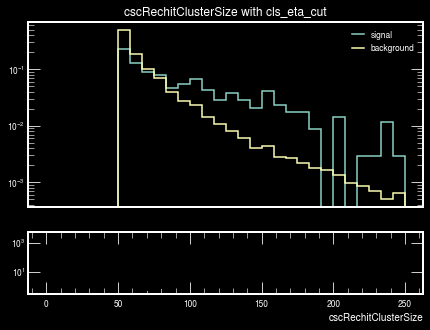

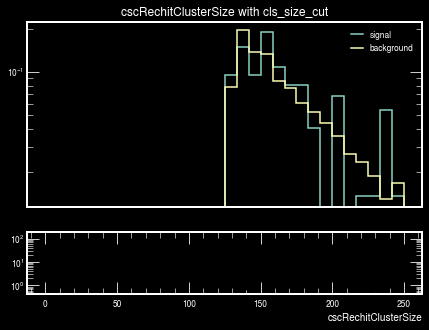

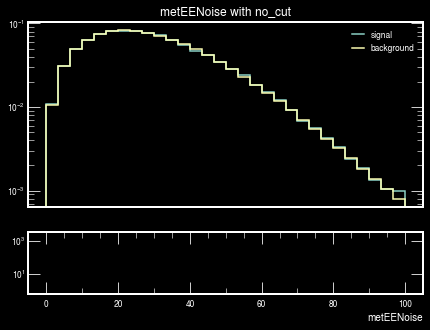

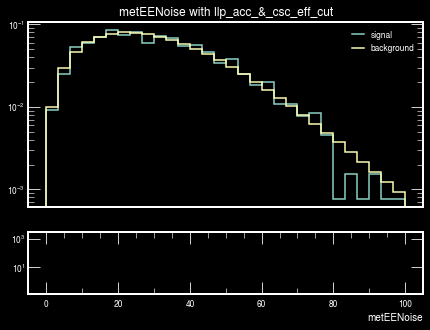

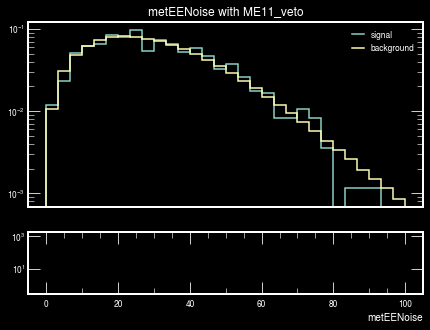

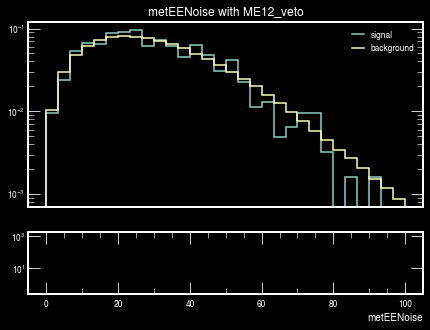

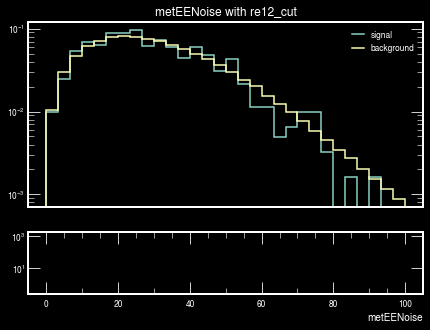

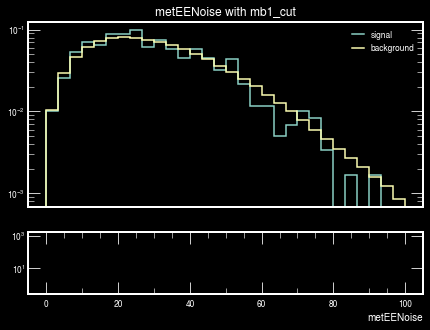

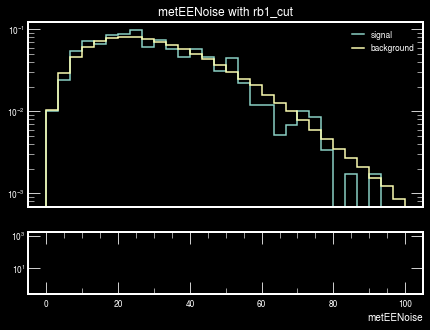

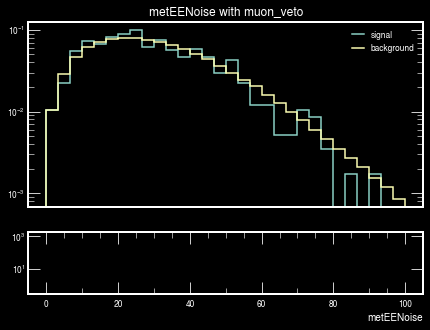

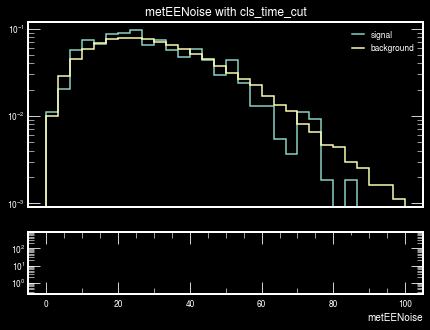

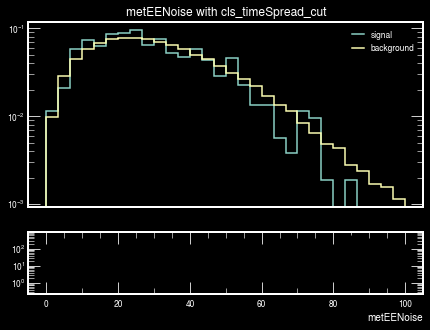

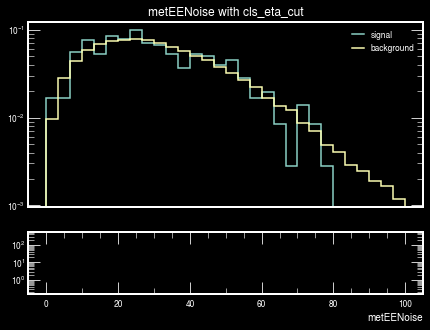

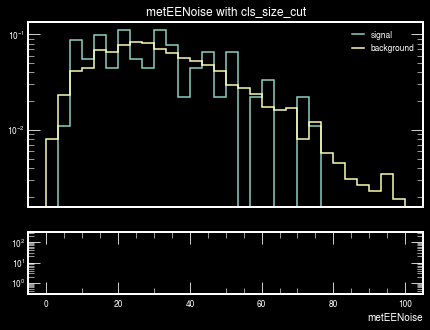

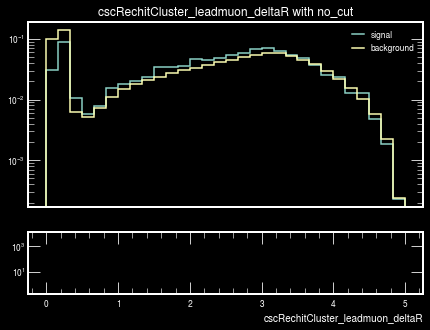

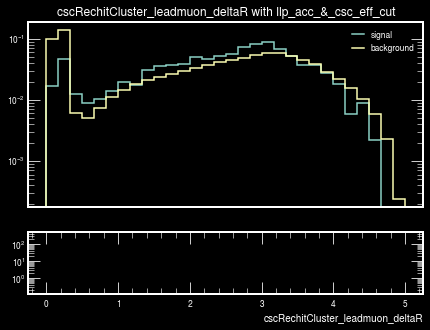

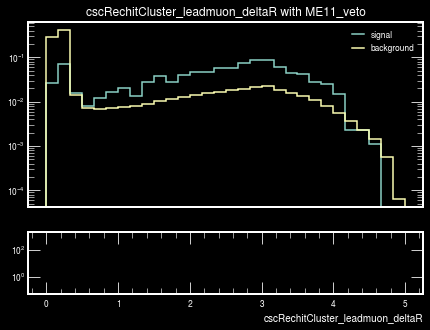

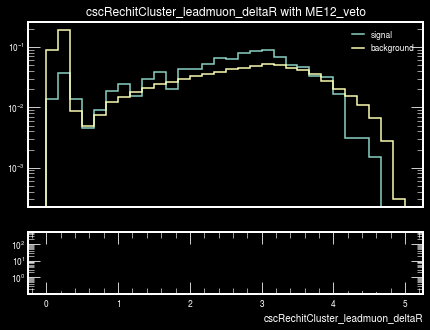

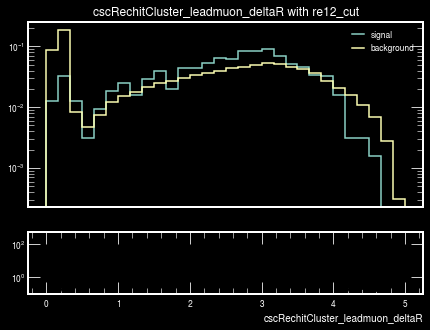

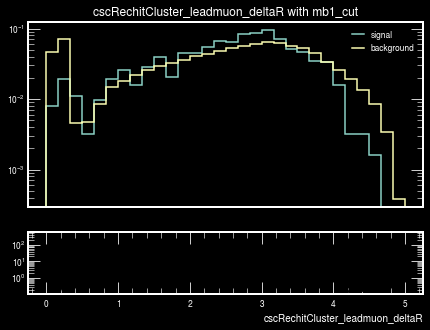

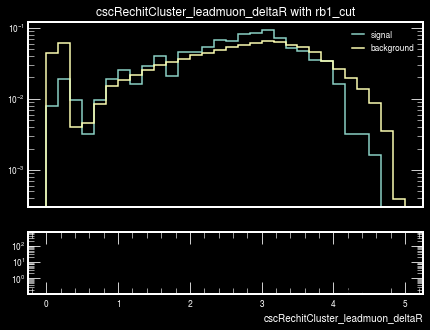

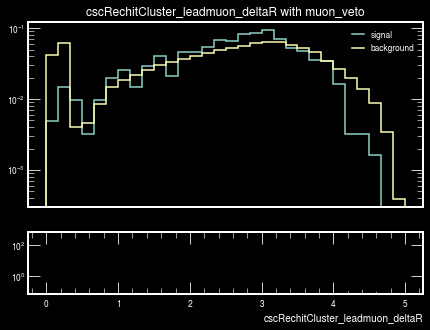

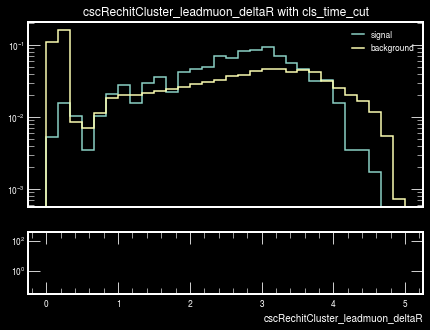

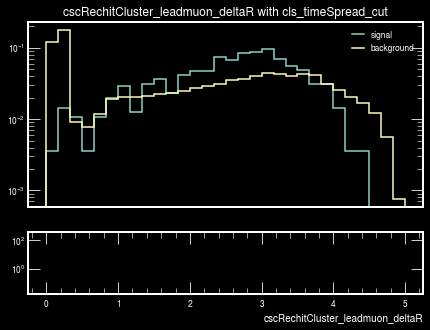

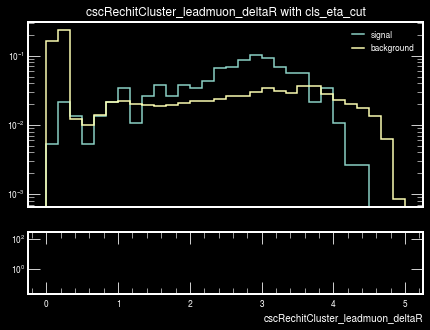

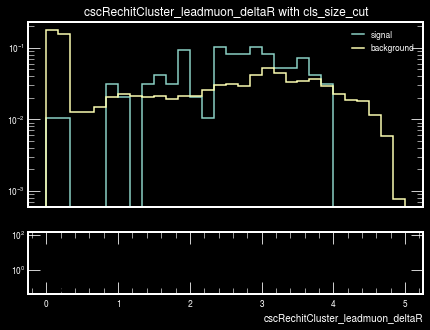

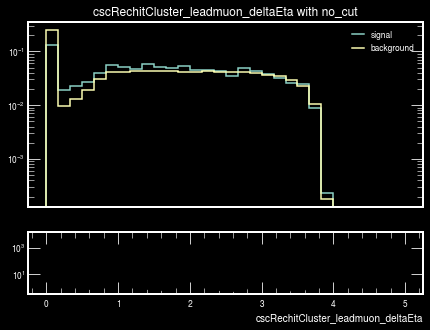

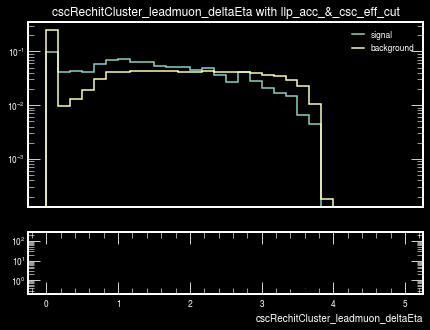

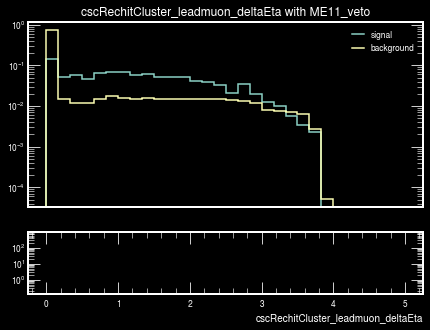

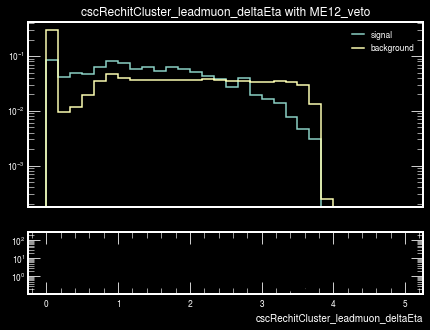

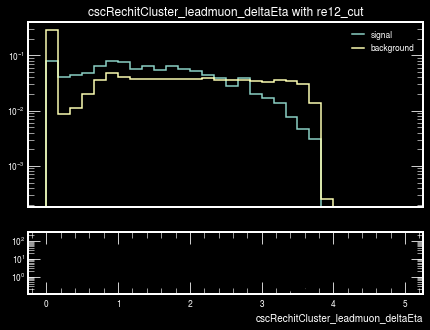

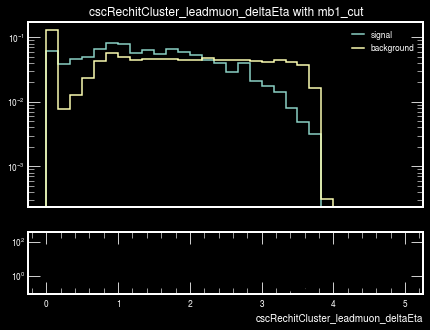

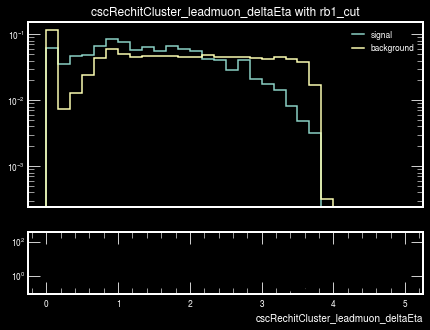

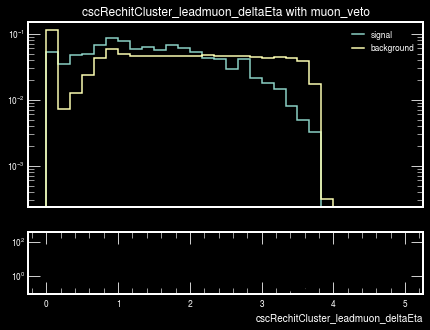

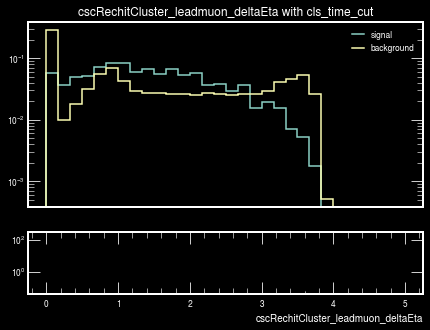

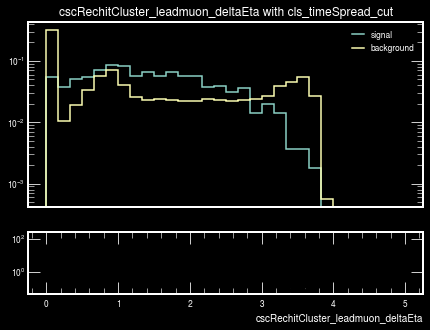

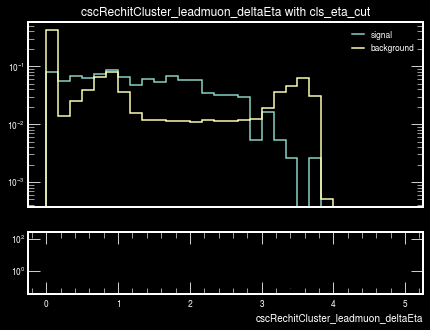

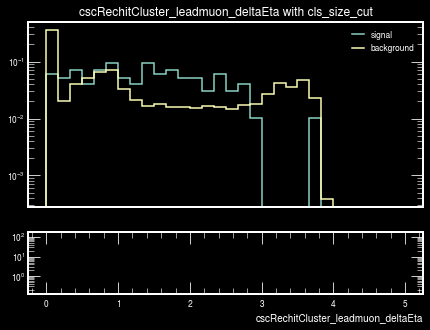

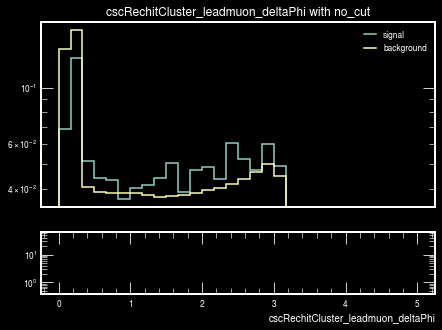

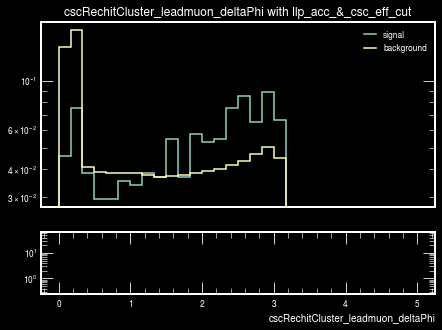

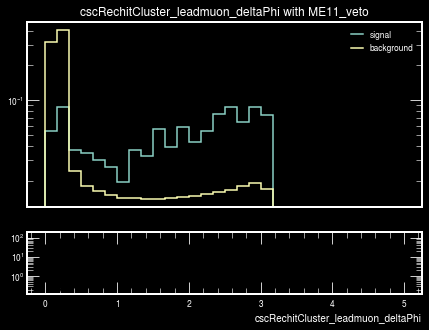

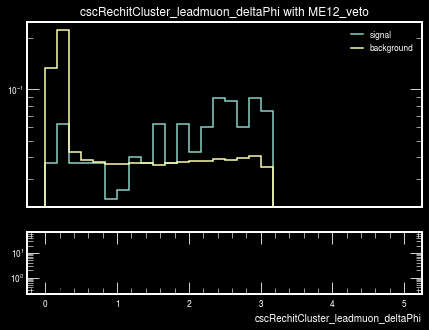

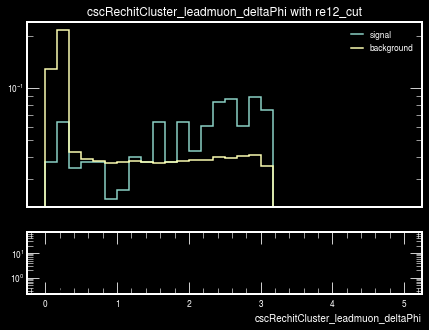

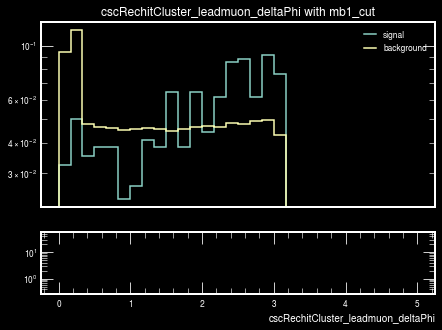

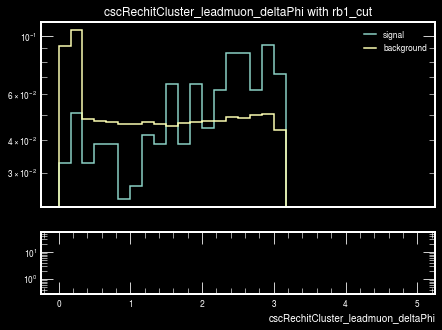

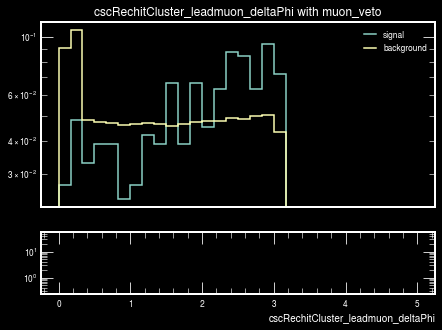

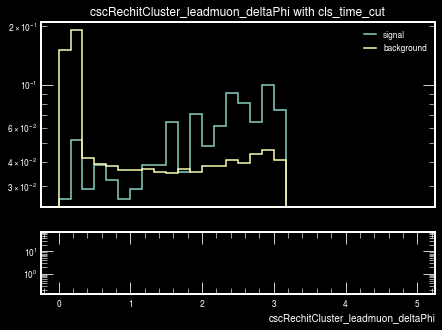

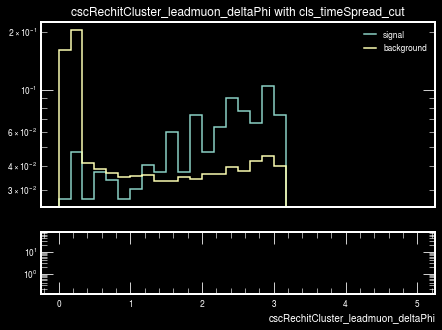

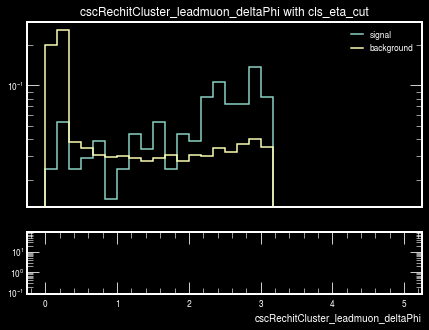

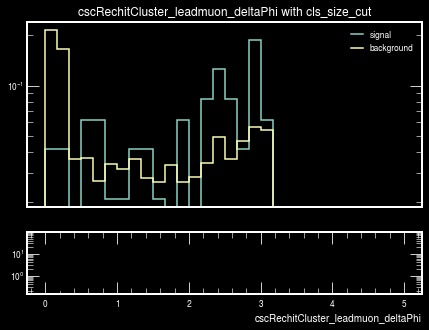

In [47]:
date = today.strftime("%m_%d_%y")
for var in bkgvars:
    pdf = PdfPages(f'varPlots_sb_{date}/{var}_cutflow_sb.pdf')
    for cut in bkgcuts:
        fig = sb_plotter(var, cut);
        pdf.savefig(fig)

    pdf.close()

In [21]:
def ratio(varname, cut, ax):
    
    signal = out['signal'][f'{varname} with {cut}']
    background = out['background'][f'{varname} with {cut}']
    num = signal/signal.sum()
    den = background/background.sum()
    
    ax.errorbar(
        x=num.axes[0].centers,
        y=num.view() / den.view() ,
        yerr=ratio_uncertainty(num.view(), den.view()),
        color="k",
        linestyle="none",
        marker="o",
        elinewidth=1,
    )
    return ax

def sb_plotter(varname, cut, ax):
    signal = out['signal'][f'{varname} with {cut}']
    background = out['background'][f'{varname} with {cut}']

    hep.histplot(signal/signal.sum(), label='signal', ax=ax)
    hep.histplot(background/background.sum(), label='background', ax=ax)
    ax.set_title(f'{varname} with {cut}')
    ax.legend()
    # ax.tick_params(
    #     axis='x',          # changes apply to the x-axis
    #     which='both',      # both major and minor ticks are affected
    #     bottom=False,      # ticks along the bottom edge are off
    #     top=False,         # ticks along the top edge are off
    #     labelbottom=False) # labels along the bottom edge are off
    ax.set(xlabel=None)
    ax.set_yscale('log')
    return ax


def sb_plotter_ratio(varname, cut, ax):
    ax[0] = sb_plotter(varname, cut, ax[0])
    ax[1] = ratio(varname, cut, ax[1])

    ax[1].set_xlim(ax[0].get_xlim())
    #ax[1].set_ylim((0,2))
    ax[1].set(xlabel=varname)
    ax[1].set_yscale('log')
    return ax  
    

/tmp/ipykernel_22681/1312059894.py:10: RuntimeWarning: invalid value encountered in true_divide
  y=num.view() / den.view() ,
/tmp/ipykernel_22681/1312059894.py:10: RuntimeWarning: invalid value encountered in true_divide
  y=num.view() / den.view() ,
/tmp/ipykernel_22681/1312059894.py:10: RuntimeWarning: divide by zero encountered in true_divide
  y=num.view() / den.view() ,
/tmp/ipykernel_22681/1312059894.py:10: RuntimeWarning: invalid value encountered in true_divide
  y=num.view() / den.view() ,
/tmp/ipykernel_22681/1312059894.py:10: RuntimeWarning: invalid value encountered in true_divide
  y=num.view() / den.view() ,
/tmp/ipykernel_22681/1312059894.py:10: RuntimeWarning: divide by zero encountered in true_divide
  y=num.view() / den.view() ,
/tmp/ipykernel_22681/1312059894.py:10: RuntimeWarning: invalid value encountered in true_divide
  y=num.view() / den.view() ,
/tmp/ipykernel_22681/1312059894.py:10: RuntimeWarning: divide by zero encountered in true_divide
  y=num.view() / de

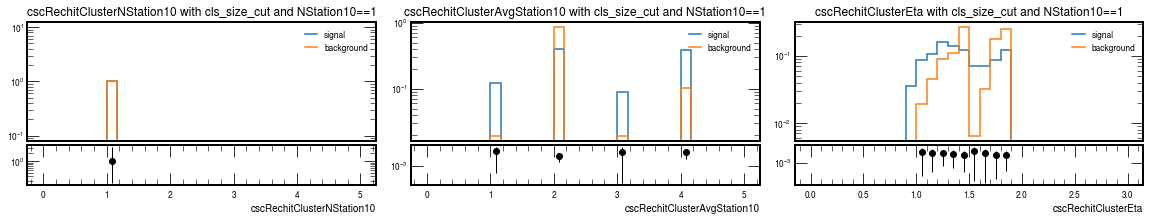

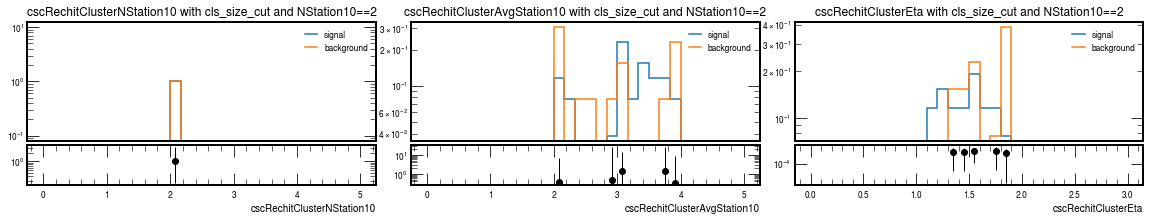

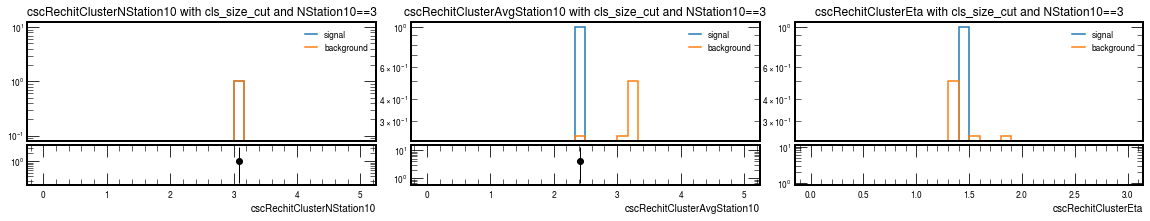

In [175]:
cut = 'cls_size_cut'
for i in range(3):
    fig, ax = plt.subplots(2,3, gridspec_kw={'height_ratios': [3, 1]}, figsize = (20,3))
    fig.subplots_adjust(hspace=.05, wspace=.1)
    sb_plotter_ratio('cscRechitClusterNStation10', f'{cut} and NStation10=={i+1}', [ax[0,0],ax[1,0]])
    sb_plotter_ratio('cscRechitClusterAvgStation10', f'{cut} and NStation10=={i+1}', [ax[0,1],ax[1,1]])
    sb_plotter_ratio('cscRechitClusterEta', f'{cut} and NStation10=={i+1}', [ax[0,2],ax[1,2]])


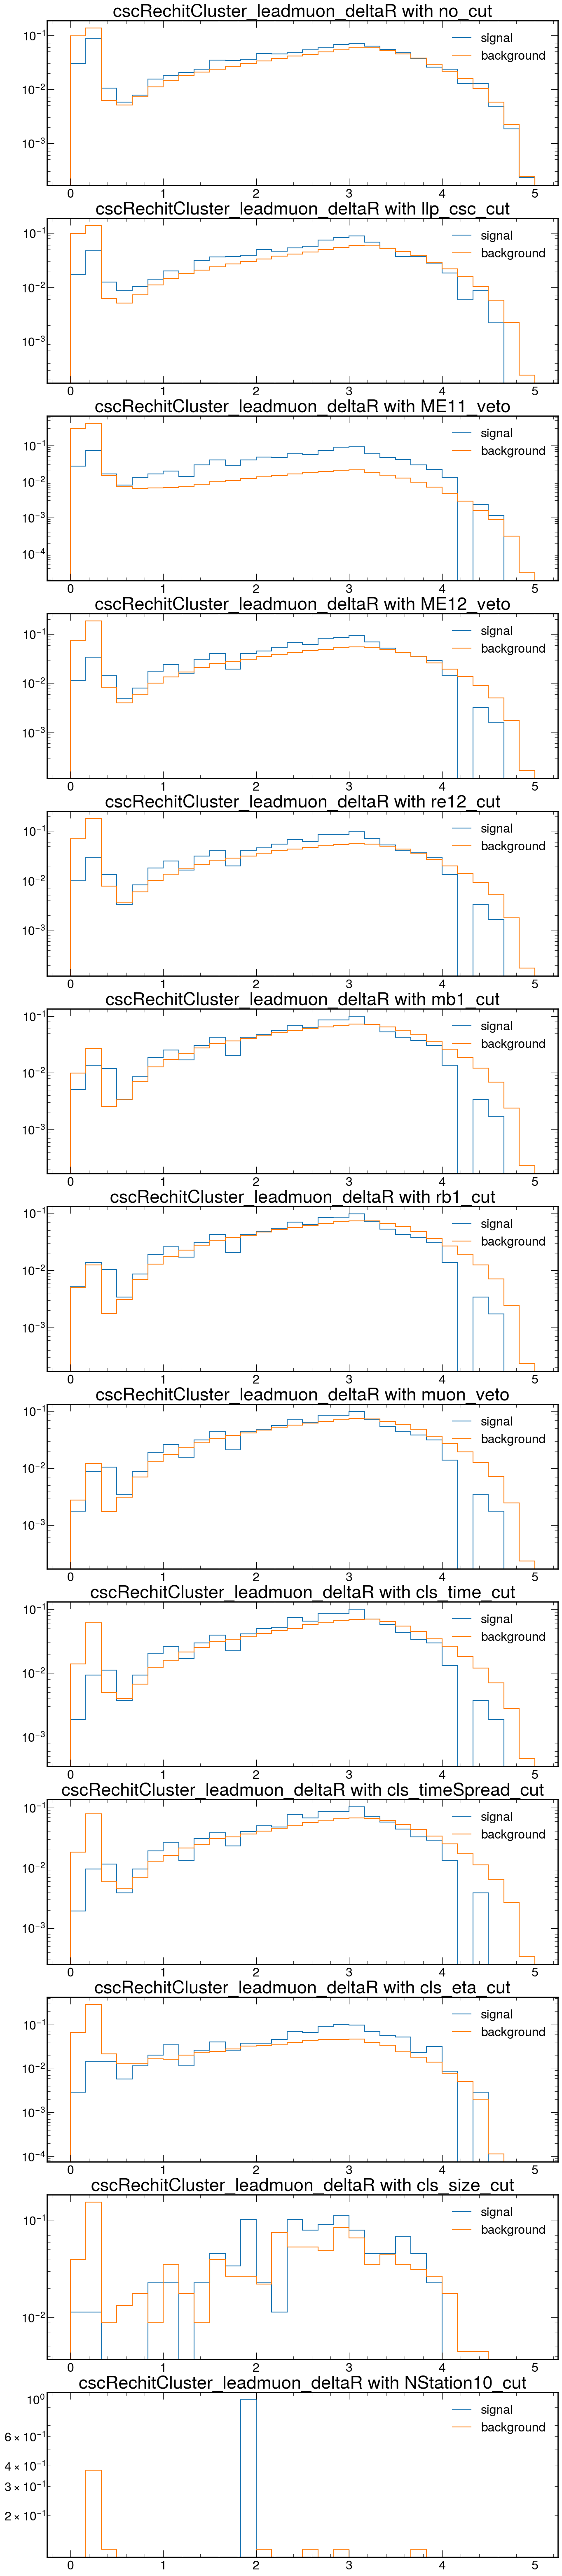

In [26]:
fig, ax = plt.subplots(len(bkgcuts), 1, figsize = (16, 80))
for i, cut in enumerate(bkgcuts):
    sb_plotter('cscRechitCluster_leadmuon_deltaR', cut, ax[i])